# 去共线性

In [2]:
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
from scipy.cluster import hierarchy
from scipy.spatial.distance import pdist, squareform
from collections import defaultdict
from sklearn.ensemble import GradientBoostingClassifier
from sklearn.model_selection import StratifiedKFold
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import roc_auc_score


# 设置参数
dpath = 'C:/Users/74101/Desktop/成人抑郁症/'
result_path = dpath + 'result/12.5/result/mdd_ranking/'

# 加载数据
df = pd.read_csv(dpath + 'data/all.csv', encoding='GBK')

# 分组
train_df = df[df.iloc[:, 0].str.startswith('train')]
test_df = df[df.iloc[:, 0].str.startswith('test')]

# 过滤训练集并处理group列
train_df_filtered = train_df[train_df['group'].isin([1, 0, 3])]
train_df_filtered['group'] = train_df_filtered['group'].replace({3: 0})

df_group = train_df_filtered['group']
df_feature = train_df_filtered.drop(columns=['allRNA', 'Hospital', 'Sample_id', 'Company', 'Batch', 'group', 'Age', 'HAMD', 'Diagnosis', 'Gender'])

# 计算Spearman相关性矩阵并保存
correlation_matrix = df_feature.corr(method='spearman')
correlation_matrix.to_csv(result_path + 'mdd_correlation_matrix.csv', index=True)

# 将相关性矩阵转换为距离矩阵 (1 - 绝对值相关性)
distance_matrix = 1 - np.abs(correlation_matrix)
dist_array = squareform(distance_matrix)  # 压缩距离矩阵
dist_linkage = hierarchy.linkage(dist_array, method='ward')  # 层次聚类

# # 绘制树状图并保存为PDF
# fig, ax = plt.subplots(figsize=(30, 16))
# dendro = hierarchy.dendrogram(dist_linkage, labels=correlation_matrix.columns, ax=ax)
# ax.set_xticklabels(dendro["ivl"], rotation=60, fontsize=4, horizontalalignment='right')
# ax.axhline(y=0.5, color='r', linewidth=2, linestyle='--')
# pdf_output_file = result_path + 'MDD_hc_dendrogram.pdf'
# plt.savefig(pdf_output_file, dpi=300, format='pdf')
# # plt.show()

# 聚类并输出特征和簇ID
cluster_ids = hierarchy.fcluster(dist_linkage, 0.5, criterion="distance")
feature_names = df_feature.columns.tolist()
cluster_data = pd.DataFrame({'RNA_feature': feature_names, 'ClusterID': cluster_ids})
output_csv = result_path + 'mdd_feature_clusters.csv'
cluster_data.to_csv(output_csv, index=False)
print(f"聚类结果已保存至: {output_csv}")

# 设置模型参数
params = {'max_depth': 30, 'min_samples_leaf': 1, 'min_samples_split': 2, 'n_estimators': 100}
cv = StratifiedKFold(n_splits=10, shuffle=True, random_state=42)

# 计算AUC函数
def calculate_auc_for_feature(RNA_feature, df_feature, df_group, cv, params):
    aucs = []
    for train_idx, test_idx in cv.split(df_feature, df_group):
        X_train, X_test = df_feature.iloc[train_idx], df_feature.iloc[test_idx]
        y_train, y_test = df_group.iloc[train_idx], df_group.iloc[test_idx]
        
        model = RandomForestClassifier(**params)
        model.fit(X_train[[RNA_feature]], y_train)
        
        y_pred_prob = model.predict_proba(X_test[[RNA_feature]])[:, 1]
        auc = roc_auc_score(y_test, y_pred_prob)
        aucs.append(auc)
    
    return np.mean(aucs)

# 计算每个RNA的AUC并保存
auc_scores = {RNA_feature: calculate_auc_for_feature(RNA_feature, df_feature, df_group, cv, params) 
              for RNA_feature in df_feature.columns}

auc_df = pd.DataFrame(list(auc_scores.items()), columns=['RNA_feature', 'AUC'])
output_auc_file = result_path + 'mdd_auc_scores.csv'
auc_df.to_csv(output_auc_file, index=False)
print(f"AUC scores have been saved to {output_auc_file}")

# 读取AUC分数并合并聚类结果，选择最佳特征
feature_auc = pd.read_csv(result_path + 'mdd_auc_scores.csv', encoding='GBK')
feature_clus = pd.read_csv(result_path + 'mdd_feature_clusters.csv', encoding='GBK')
feature_sel = pd.merge(feature_auc, feature_clus, how='left', on="RNA_feature")
best_features = feature_sel.loc[feature_sel.groupby('ClusterID')['AUC'].idxmax()]
output_best_features = result_path + 'mdd_best_features.csv'
best_features.to_csv(output_best_features, index=False)
print(f"最佳特征已保存至: {output_best_features}")

C:\Users\74101\AppData\Local\Temp\ipykernel_41828\1963310728.py:27: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  train_df_filtered['group'] = train_df_filtered['group'].replace({3: 0})


聚类结果已保存至: C:/Users/74101/Desktop/成人抑郁症/result/12.5/result/mdd_ranking/mdd_feature_clusters.csv
AUC scores have been saved to C:/Users/74101/Desktop/成人抑郁症/result/12.5/result/mdd_ranking/mdd_auc_scores.csv
最佳特征已保存至: C:/Users/74101/Desktop/成人抑郁症/result/12.5/result/mdd_ranking/mdd_best_features.csv


# 去共线性后训练

In [4]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.model_selection import GridSearchCV, StratifiedKFold
from sklearn.metrics import (
    roc_auc_score, accuracy_score, confusion_matrix, roc_curve, 
    precision_score, recall_score, f1_score, matthews_corrcoef
)
from sklearn.linear_model import LogisticRegression
from sklearn.svm import SVC
from sklearn.ensemble import RandomForestClassifier, GradientBoostingClassifier, AdaBoostClassifier
from sklearn.naive_bayes import GaussianNB
from sklearn.neural_network import MLPClassifier
import xgboost as xgb
import lightgbm as lgb
from catboost import CatBoostClassifier

In [15]:
feature_sel = best_features['RNA_feature']
mirna_group = df_group = train_df_filtered['group']
mirna_feature = df_feature = train_df_filtered[feature_sel]

In [6]:
# 定义模型的参数网格
param_grids = {
    'Logistic Regression': {
        'C': [0.01, 0.1, 1, 10, 100],
        'solver': ['saga'],
        'penalty': ['l2'],
        'max_iter': [10000]
    },
    'SVM': {
        'C': [0.1, 1, 10, 100],
        'kernel': ['rbf'],
        'gamma': ['scale', 'auto']
    },
    'Random Forest': {
        'n_estimators': [100, 200, 300],
        'max_depth': [None, 10, 20, 30],
        'min_samples_split': [2, 5, 10],
        'min_samples_leaf': [1, 2, 4]
    },
    'GNB': {
        'var_smoothing': [1e-9, 1e-8, 1e-7, 1e-6, 1e-5]
    },
    'MLP': {
        'hidden_layer_sizes': [(10,), (50,), (10, 50), (50, 50)],
        'activation': ['relu', 'tanh'],
        'solver': ['adam'],
        'alpha': [0.0001, 0.001, 0.01],
        'learning_rate': ['constant', 'adaptive']
    },
    'GBDT': {
        'n_estimators': [100, 200, 300],
        'learning_rate': [0.01, 0.1, 0.2],
        'max_depth': [3, 5, 7],
        'subsample': [0.7, 0.8, 1.0]
    },
    'XGBoost': {
        'n_estimators': [100, 200, 300],
        'learning_rate': [0.01, 0.1, 0.2],
        'max_depth': [3, 5, 7],
        'subsample': [0.7, 0.8, 1.0]
    },
    'LightGBM': {
        'n_estimators': [100, 200, 300],
        'learning_rate': [0.01, 0.1, 0.2],
        'num_leaves': [31, 50, 100],
        'boosting_type': ['gbdt'],
        'subsample': [0.7, 0.8, 1.0]
    },
    'CatBoost': {
        'iterations': [100, 200, 300],
        'learning_rate': [0.01, 0.1, 0.2],
        'depth': [3, 5, 7]
    },
    'AdaBoost': {
        'n_estimators': [50, 100, 200],
        'learning_rate': [0.01, 0.1, 1.0]
    }
}

# 定义模型
models = {
    'Logistic Regression': LogisticRegression(),
    'SVM': SVC(probability=True),
    'Random Forest': RandomForestClassifier(),
    'GNB': GaussianNB(),
    'MLP': MLPClassifier(),
    'GBDT': GradientBoostingClassifier(),
    'XGBoost': xgb.XGBClassifier(),
    'LightGBM': lgb.LGBMClassifier(),
    'CatBoost': CatBoostClassifier(verbose=0),
    'AdaBoost': AdaBoostClassifier()
}

# 交叉验证
cv = StratifiedKFold(n_splits=3, shuffle=True, random_state=42)

# 保存最优参数和模型
best_params = {}
best_models = {}

# 超参数优化
for model_name, model in models.items():
    if model_name in param_grids:
        param_grid = param_grids[model_name]
        grid_search = GridSearchCV(model, param_grid, cv=cv, scoring='roc_auc', n_jobs=-1)
        grid_search.fit(df_feature, df_group)
        best_params[model_name] = grid_search.best_params_
        best_models[model_name] = grid_search.best_estimator_
        print(f"Best parameters for {model_name}: {grid_search.best_params_}")
    else:
        model.fit(df_feature, df_group)
        best_models[model_name] = model
        print(f"{model_name} has no hyperparameters to tune.")

Best parameters for Logistic Regression: {'C': 1, 'max_iter': 10000, 'penalty': 'l2', 'solver': 'saga'}
Best parameters for SVM: {'C': 100, 'gamma': 'scale', 'kernel': 'rbf'}
Best parameters for Random Forest: {'max_depth': 20, 'min_samples_leaf': 1, 'min_samples_split': 5, 'n_estimators': 100}
Best parameters for GNB: {'var_smoothing': 1e-09}


c:\Users\74101\Desktop\MCY-BI\conda\Lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:690: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  warnings.warn(


Best parameters for MLP: {'activation': 'relu', 'alpha': 0.001, 'hidden_layer_sizes': (10,), 'learning_rate': 'adaptive', 'solver': 'adam'}
Best parameters for GBDT: {'learning_rate': 0.2, 'max_depth': 3, 'n_estimators': 300, 'subsample': 0.8}
Best parameters for XGBoost: {'learning_rate': 0.1, 'max_depth': 5, 'n_estimators': 300, 'subsample': 0.7}
[LightGBM] [Info] Number of positive: 202, number of negative: 413
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.006472 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 88067
[LightGBM] [Info] Number of data points in the train set: 615, number of used features: 482
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.328455 -> initscore=-0.715180
[LightGBM] [Info] Start training from score -0.715180
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM

c:\Users\74101\Desktop\MCY-BI\conda\Lib\site-packages\sklearn\ensemble\_weight_boosting.py:527: FutureWarning: The SAMME.R algorithm (the default) is deprecated and will be removed in 1.6. Use the SAMME algorithm to circumvent this warning.
  warnings.warn(


Best parameters for AdaBoost: {'learning_rate': 1.0, 'n_estimators': 200}


In [7]:
# 保存最佳参数到文件
best_params_df = pd.DataFrame(list(best_params.items()), columns=['Model', 'Best Parameters'])
best_params_df['Best Parameters'] = best_params_df['Best Parameters'].apply(lambda x: str(x))  # 转换为字符串
best_params_df.to_csv(result_path + 'best_params.csv', index=False, encoding='utf-8-sig')

print("Best parameters saved to 'best_params.csv'")

# 扁平化字典
best_params_flat = {model: params for model, params in best_params.items()}
best_params_df = pd.json_normalize(best_params_flat).reset_index()
best_params_df.rename(columns={'index': 'Model'}, inplace=True)  # 重命名索引列为 'Model'
best_params_df.to_csv(result_path + 'best_params2.csv', index=False, encoding='utf-8-sig')

print("Best parameters saved to 'best_params.csv'")

Best parameters saved to 'best_params.csv'
Best parameters saved to 'best_params.csv'


In [18]:
from sklearn.utils import resample
from sklearn.metrics import roc_auc_score, accuracy_score, precision_score, f1_score, matthews_corrcoef, roc_curve, confusion_matrix
from sklearn.model_selection import StratifiedKFold
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

# 自定义评分函数
def sensitivity_score(y_true, y_pred):
    cm = confusion_matrix(y_true, y_pred)
    return cm[1, 1] / (cm[1, 1] + cm[1, 0])

def specificity_score(y_true, y_pred):
    cm = confusion_matrix(y_true, y_pred)
    return cm[0, 0] / (cm[0, 0] + cm[0, 1])

def youden_index_score(y_true, y_pred):
    sensitivity = sensitivity_score(y_true, y_pred)
    specificity = specificity_score(y_true, y_pred)
    return sensitivity + specificity - 1

# 交叉验证配置
cv = StratifiedKFold(n_splits=10, shuffle=True, random_state=42)

# 存储交叉验证结果
results = []
roc_curves = {}

# 对每个模型进行交叉验证
for name, model in best_models.items():
    auc_scores = []
    accuracy_scores = []
    sensitivity_scores = []
    specificity_scores = []
    youden_index_scores = []
    ppv_scores = []
    npv_scores = []
    f1_scores = []
    mcc_scores = []

    y_true_all = []
    y_pred_proba_all = []

    for train_index, test_index in cv.split(mirna_feature, mirna_group):
        X_train_fold, X_test_fold = mirna_feature.iloc[train_index], mirna_feature.iloc[test_index]
        y_train_fold, y_test_fold = mirna_group.iloc[train_index], mirna_group.iloc[test_index]

        model.fit(X_train_fold, y_train_fold)
        y_pred_fold = model.predict(X_test_fold)
        y_pred_proba_fold = model.predict_proba(X_test_fold)[:, 1]

        y_true_all.extend(y_test_fold)
        y_pred_proba_all.extend(y_pred_proba_fold)

        # 计算各类指标
        auc_scores.append(roc_auc_score(y_test_fold, y_pred_proba_fold))
        accuracy_scores.append(accuracy_score(y_test_fold, y_pred_fold))
        sensitivity_scores.append(sensitivity_score(y_test_fold, y_pred_fold))
        specificity_scores.append(specificity_score(y_test_fold, y_pred_fold))
        youden_index_scores.append(youden_index_score(y_test_fold, y_pred_fold))
        ppv_scores.append(precision_score(y_test_fold, y_pred_fold))
        npv_scores.append(precision_score(y_test_fold, y_pred_fold, pos_label=0))
        f1_scores.append(f1_score(y_test_fold, y_pred_fold))
        mcc_scores.append(matthews_corrcoef(y_test_fold, y_pred_fold))

        results.append({
            'Model': name,
            'Fold': len(auc_scores),
            'AUC': auc_scores[-1],
            'Accuracy': accuracy_scores[-1],
            'Sensitivity': sensitivity_scores[-1],
            'Specificity': specificity_scores[-1],
            'Youden Index': youden_index_scores[-1],
            'PPV': ppv_scores[-1],
            'NPV': npv_scores[-1],
            'F1 Score': f1_scores[-1],
            'MCC': mcc_scores[-1]
        })

    fpr, tpr, _ = roc_curve(y_true_all, y_pred_proba_all)
    roc_curves[name] = (fpr, tpr, roc_auc_score(y_true_all, y_pred_proba_all))

# 计算置信区间
bootstrap_iterations = 1000
confidence_level = 95
bootstrap_results = {name: [] for name in best_models.keys()}
conf_intervals = {}

for name, model in best_models.items():
    y_true_all = []
    y_pred_proba_all = []

    for train_index, test_index in cv.split(mirna_feature, mirna_group):
        X_train_fold, X_test_fold = mirna_feature.iloc[train_index], mirna_feature.iloc[test_index]
        y_train_fold, y_test_fold = mirna_group.iloc[train_index], mirna_group.iloc[test_index]

        model.fit(X_train_fold, y_train_fold)
        y_pred_proba_fold = model.predict_proba(X_test_fold)[:, 1]

        y_true_all.extend(y_test_fold)
        y_pred_proba_all.extend(y_pred_proba_fold)

    y_true_all = np.array(y_true_all)
    y_pred_proba_all = np.array(y_pred_proba_all)

    for _ in range(bootstrap_iterations):
        y_true_bootstrap, y_pred_proba_bootstrap = resample(y_true_all, y_pred_proba_all)
        bootstrap_results[name].append(roc_auc_score(y_true_bootstrap, y_pred_proba_bootstrap))

    lower_bound = np.percentile(bootstrap_results[name], (100 - confidence_level) / 2)
    upper_bound = np.percentile(bootstrap_results[name], 100 - (100 - confidence_level) / 2)

    conf_intervals[name] = (lower_bound, upper_bound)

    print(f"{name} AUC 95% CI: {lower_bound:.4f} - {upper_bound:.4f}")

# 计算其他指标的置信区间
metrics = ['Accuracy', 'Sensitivity', 'Specificity', 'Youden Index', 'PPV', 'NPV', 'F1 Score', 'MCC']
bootstrap_metrics_results = {metric: {name: [] for name in best_models.keys()} for metric in metrics}
metrics_conf_intervals = {metric: {} for metric in metrics}

for name, model in best_models.items():
    y_true_all = []
    y_pred_all = []

    for train_index, test_index in cv.split(mirna_feature, mirna_group):
        X_train_fold, X_test_fold = mirna_feature.iloc[train_index], mirna_feature.iloc[test_index]
        y_train_fold, y_test_fold = mirna_group.iloc[train_index], mirna_group.iloc[test_index]

        model.fit(X_train_fold, y_train_fold)
        y_pred_fold = model.predict(X_test_fold)

        y_true_all.extend(y_test_fold)
        y_pred_all.extend(y_pred_fold)

    y_true_all = np.array(y_true_all)
    y_pred_all = np.array(y_pred_all)

    # 通过bootstrapping计算每个性能指标的置信区间
    for _ in range(bootstrap_iterations):
        y_true_bootstrap, y_pred_bootstrap = resample(y_true_all, y_pred_all)
        
        bootstrap_metrics_results['Accuracy'][name].append(accuracy_score(y_true_bootstrap, y_pred_bootstrap))
        bootstrap_metrics_results['Sensitivity'][name].append(sensitivity_score(y_true_bootstrap, y_pred_bootstrap))
        bootstrap_metrics_results['Specificity'][name].append(specificity_score(y_true_bootstrap, y_pred_bootstrap))
        bootstrap_metrics_results['Youden Index'][name].append(youden_index_score(y_true_bootstrap, y_pred_bootstrap))
        bootstrap_metrics_results['PPV'][name].append(precision_score(y_true_bootstrap, y_pred_bootstrap))
        bootstrap_metrics_results['NPV'][name].append(precision_score(y_true_bootstrap, y_pred_bootstrap, pos_label=0))
        bootstrap_metrics_results['F1 Score'][name].append(f1_score(y_true_bootstrap, y_pred_bootstrap))
        bootstrap_metrics_results['MCC'][name].append(matthews_corrcoef(y_true_bootstrap, y_pred_bootstrap))

    # 计算95%置信区间
    for metric in metrics:
        lower_bound = np.percentile(bootstrap_metrics_results[metric][name], (100 - confidence_level) / 2)
        upper_bound = np.percentile(bootstrap_metrics_results[metric][name], 100 - (100 - confidence_level) / 2)
        metrics_conf_intervals[metric][name] = (lower_bound, upper_bound)
        print(f"{name} {metric} 95% CI: {lower_bound:.4f} - {upper_bound:.4f}")

# 保存结果为 CSV 文件
df_results = pd.DataFrame(results)
df_results.to_csv(result_path + 'cv_482rna.csv', index=False)

print("Cross-validation results saved to 'cv_results.csv'")

# 保存置信区间结果
metrics_conf_intervals_df = []
for metric in metrics:
    for name, (lower_bound, upper_bound) in metrics_conf_intervals[metric].items():
        metrics_conf_intervals_df.append({
            'Model': name,
            'Metric': metric,
            'Lower Bound': lower_bound,
            'Upper Bound': upper_bound
        })

# 转换为 DataFrame 并保存为 CSV
df_metrics_conf_intervals = pd.DataFrame(metrics_conf_intervals_df)
df_metrics_conf_intervals.to_csv(result_path + 'metrics_conf_intervals.csv', index=False)
print("Metrics confidence intervals saved to 'metrics_conf_intervals.csv'")


c:\Users\74101\Desktop\MCY-BI\conda\Lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:690: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  warnings.warn(
c:\Users\74101\Desktop\MCY-BI\conda\Lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:690: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  warnings.warn(
c:\Users\74101\Desktop\MCY-BI\conda\Lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:690: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  warnings.warn(
c:\Users\74101\Desktop\MCY-BI\conda\Lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:690: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  warnings.warn(


[LightGBM] [Info] Number of positive: 182, number of negative: 371
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.005079 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 77375
[LightGBM] [Info] Number of data points in the train set: 553, number of used features: 482
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.329114 -> initscore=-0.712195
[LightGBM] [Info] Start training from score -0.712195
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, b

c:\Users\74101\Desktop\MCY-BI\conda\Lib\site-packages\sklearn\ensemble\_weight_boosting.py:527: FutureWarning: The SAMME.R algorithm (the default) is deprecated and will be removed in 1.6. Use the SAMME algorithm to circumvent this warning.
  warnings.warn(
c:\Users\74101\Desktop\MCY-BI\conda\Lib\site-packages\sklearn\ensemble\_weight_boosting.py:527: FutureWarning: The SAMME.R algorithm (the default) is deprecated and will be removed in 1.6. Use the SAMME algorithm to circumvent this warning.
  warnings.warn(
c:\Users\74101\Desktop\MCY-BI\conda\Lib\site-packages\sklearn\ensemble\_weight_boosting.py:527: FutureWarning: The SAMME.R algorithm (the default) is deprecated and will be removed in 1.6. Use the SAMME algorithm to circumvent this warning.
  warnings.warn(
c:\Users\74101\Desktop\MCY-BI\conda\Lib\site-packages\sklearn\ensemble\_weight_boosting.py:527: FutureWarning: The SAMME.R algorithm (the default) is deprecated and will be removed in 1.6. Use the SAMME algorithm to circumvent

Logistic Regression AUC 95% CI: 0.9864 - 0.9966
SVM AUC 95% CI: 0.9901 - 0.9982
Random Forest AUC 95% CI: 0.9920 - 0.9994
GNB AUC 95% CI: 0.9013 - 0.9494


c:\Users\74101\Desktop\MCY-BI\conda\Lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:690: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  warnings.warn(
c:\Users\74101\Desktop\MCY-BI\conda\Lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:690: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  warnings.warn(
c:\Users\74101\Desktop\MCY-BI\conda\Lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:690: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  warnings.warn(
c:\Users\74101\Desktop\MCY-BI\conda\Lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:690: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  warnings.warn(
c:\Users\74101\Desktop\MCY-B

MLP AUC 95% CI: 0.9737 - 0.9930
GBDT AUC 95% CI: 0.9891 - 0.9988
XGBoost AUC 95% CI: 0.9932 - 0.9997
[LightGBM] [Info] Number of positive: 182, number of negative: 371
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.004431 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 77375
[LightGBM] [Info] Number of data points in the train set: 553, number of used features: 482
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.329114 -> initscore=-0.712195
[LightGBM] [Info] Start training from score -0.712195
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further sp

c:\Users\74101\Desktop\MCY-BI\conda\Lib\site-packages\sklearn\ensemble\_weight_boosting.py:527: FutureWarning: The SAMME.R algorithm (the default) is deprecated and will be removed in 1.6. Use the SAMME algorithm to circumvent this warning.
  warnings.warn(
c:\Users\74101\Desktop\MCY-BI\conda\Lib\site-packages\sklearn\ensemble\_weight_boosting.py:527: FutureWarning: The SAMME.R algorithm (the default) is deprecated and will be removed in 1.6. Use the SAMME algorithm to circumvent this warning.
  warnings.warn(
c:\Users\74101\Desktop\MCY-BI\conda\Lib\site-packages\sklearn\ensemble\_weight_boosting.py:527: FutureWarning: The SAMME.R algorithm (the default) is deprecated and will be removed in 1.6. Use the SAMME algorithm to circumvent this warning.
  warnings.warn(
c:\Users\74101\Desktop\MCY-BI\conda\Lib\site-packages\sklearn\ensemble\_weight_boosting.py:527: FutureWarning: The SAMME.R algorithm (the default) is deprecated and will be removed in 1.6. Use the SAMME algorithm to circumvent

AdaBoost AUC 95% CI: 0.9990 - 1.0000
Logistic Regression Accuracy 95% CI: 0.9496 - 0.9789
Logistic Regression Sensitivity 95% CI: 0.8945 - 0.9639
Logistic Regression Specificity 95% CI: 0.9656 - 0.9928
Logistic Regression Youden Index 95% CI: 0.8750 - 0.9471
Logistic Regression PPV 95% CI: 0.9272 - 0.9845
Logistic Regression NPV 95% CI: 0.9474 - 0.9828
Logistic Regression F1 Score 95% CI: 0.9219 - 0.9670
Logistic Regression MCC 95% CI: 0.8865 - 0.9519
SVM Accuracy 95% CI: 0.9545 - 0.9821
SVM Sensitivity 95% CI: 0.9021 - 0.9667
SVM Specificity 95% CI: 0.9733 - 0.9952
SVM Youden Index 95% CI: 0.8846 - 0.9559
SVM PPV 95% CI: 0.9426 - 0.9900
SVM NPV 95% CI: 0.9525 - 0.9837
SVM F1 Score 95% CI: 0.9303 - 0.9730
SVM MCC 95% CI: 0.8980 - 0.9600
Random Forest Accuracy 95% CI: 0.9561 - 0.9821
Random Forest Sensitivity 95% CI: 0.8670 - 0.9474
Random Forest Specificity 95% CI: 1.0000 - 1.0000
Random Forest Youden Index 95% CI: 0.8670 - 0.9474
Random Forest PPV 95% CI: 1.0000 - 1.0000
Random Forest

c:\Users\74101\Desktop\MCY-BI\conda\Lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:690: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  warnings.warn(
c:\Users\74101\Desktop\MCY-BI\conda\Lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:690: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  warnings.warn(


MLP Accuracy 95% CI: 0.8976 - 0.9415
MLP Sensitivity 95% CI: 0.7614 - 0.8693
MLP Specificity 95% CI: 0.9537 - 0.9855
MLP Youden Index 95% CI: 0.7317 - 0.8430
MLP PPV 95% CI: 0.8956 - 0.9671
MLP NPV 95% CI: 0.8886 - 0.9400
MLP F1 Score 95% CI: 0.8346 - 0.9064
MLP MCC 95% CI: 0.7673 - 0.8659
GBDT Accuracy 95% CI: 0.9561 - 0.9837
GBDT Sensitivity 95% CI: 0.9075 - 0.9716
GBDT Specificity 95% CI: 0.9726 - 0.9952
GBDT Youden Index 95% CI: 0.8913 - 0.9598
GBDT PPV 95% CI: 0.9418 - 0.9901
GBDT NPV 95% CI: 0.9551 - 0.9860
GBDT F1 Score 95% CI: 0.9318 - 0.9750
GBDT MCC 95% CI: 0.9009 - 0.9623
XGBoost Accuracy 95% CI: 0.9691 - 0.9919
XGBoost Sensitivity 95% CI: 0.9124 - 0.9765
XGBoost Specificity 95% CI: 0.9925 - 1.0000
XGBoost Youden Index 95% CI: 0.9110 - 0.9748
XGBoost PPV 95% CI: 0.9834 - 1.0000
XGBoost NPV 95% CI: 0.9576 - 0.9885
XGBoost F1 Score 95% CI: 0.9516 - 0.9872
XGBoost MCC 95% CI: 0.9301 - 0.9814
[LightGBM] [Info] Number of positive: 182, number of negative: 371
[LightGBM] [Info] Au

c:\Users\74101\Desktop\MCY-BI\conda\Lib\site-packages\sklearn\ensemble\_weight_boosting.py:527: FutureWarning: The SAMME.R algorithm (the default) is deprecated and will be removed in 1.6. Use the SAMME algorithm to circumvent this warning.
  warnings.warn(
c:\Users\74101\Desktop\MCY-BI\conda\Lib\site-packages\sklearn\ensemble\_weight_boosting.py:527: FutureWarning: The SAMME.R algorithm (the default) is deprecated and will be removed in 1.6. Use the SAMME algorithm to circumvent this warning.
  warnings.warn(
c:\Users\74101\Desktop\MCY-BI\conda\Lib\site-packages\sklearn\ensemble\_weight_boosting.py:527: FutureWarning: The SAMME.R algorithm (the default) is deprecated and will be removed in 1.6. Use the SAMME algorithm to circumvent this warning.
  warnings.warn(
c:\Users\74101\Desktop\MCY-BI\conda\Lib\site-packages\sklearn\ensemble\_weight_boosting.py:527: FutureWarning: The SAMME.R algorithm (the default) is deprecated and will be removed in 1.6. Use the SAMME algorithm to circumvent

AdaBoost Accuracy 95% CI: 0.9886 - 1.0000
AdaBoost Sensitivity 95% CI: 0.9667 - 1.0000
AdaBoost Specificity 95% CI: 1.0000 - 1.0000
AdaBoost Youden Index 95% CI: 0.9667 - 1.0000
AdaBoost PPV 95% CI: 1.0000 - 1.0000
AdaBoost NPV 95% CI: 0.9833 - 1.0000
AdaBoost F1 Score 95% CI: 0.9830 - 1.0000
AdaBoost MCC 95% CI: 0.9748 - 1.0000
Cross-validation results saved to 'cv_results.csv'
Metrics confidence intervals saved to 'metrics_conf_intervals.csv'


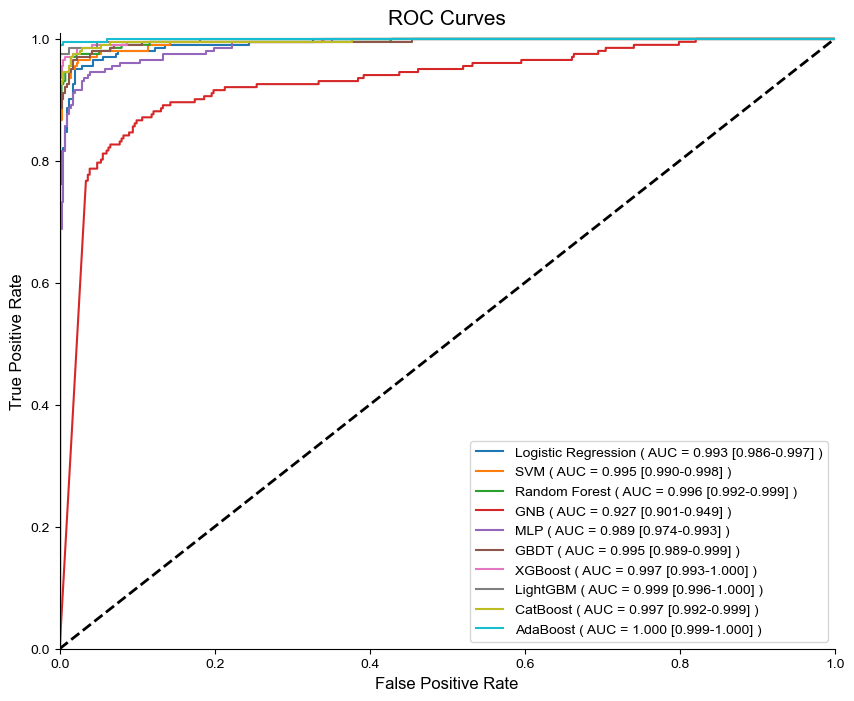

In [20]:
# 绘制ROC曲线

# 设置字体为Arial
plt.rcParams['font.family'] = 'Arial'

plt.figure(figsize=(10, 8))
for name, (fpr, tpr, auc) in roc_curves.items():
    lower_bound, upper_bound = conf_intervals[name]
    plt.plot(fpr, tpr, label=f'{name} ( AUC = {auc:.3f} [{lower_bound:.3f}-{upper_bound:.3f}] )')

plt.plot([0, 1], [0, 1], 'k--', lw=2)
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.01])
plt.xlabel('False Positive Rate', fontsize=12)
plt.ylabel('True Positive Rate', fontsize=12)
plt.title('ROC Curves', fontsize=15)
plt.legend(loc='lower right')

# 移除右边和上边边界
plt.gca().spines['right'].set_visible(False)
plt.gca().spines['top'].set_visible(False)

plt.grid(False)

# 保存为矢量图
plt.savefig(result_path + '482rna10折ROC.svg', format='svg')  # 保存为SVG格式
# plt.savefig('ROC_Curves.pdf', format='pdf')  # 保存为PDF格式（取消注释以使用）

plt.show()

In [21]:
##测试集标注
test_df = df[df.iloc[:, 0].str.startswith('test')]
test_df_filtered = test_df[test_df['group'].isin([1, 0])]
y_test = test_df_filtered['group']
X_test = test_df_filtered[feature_sel].fillna(0)

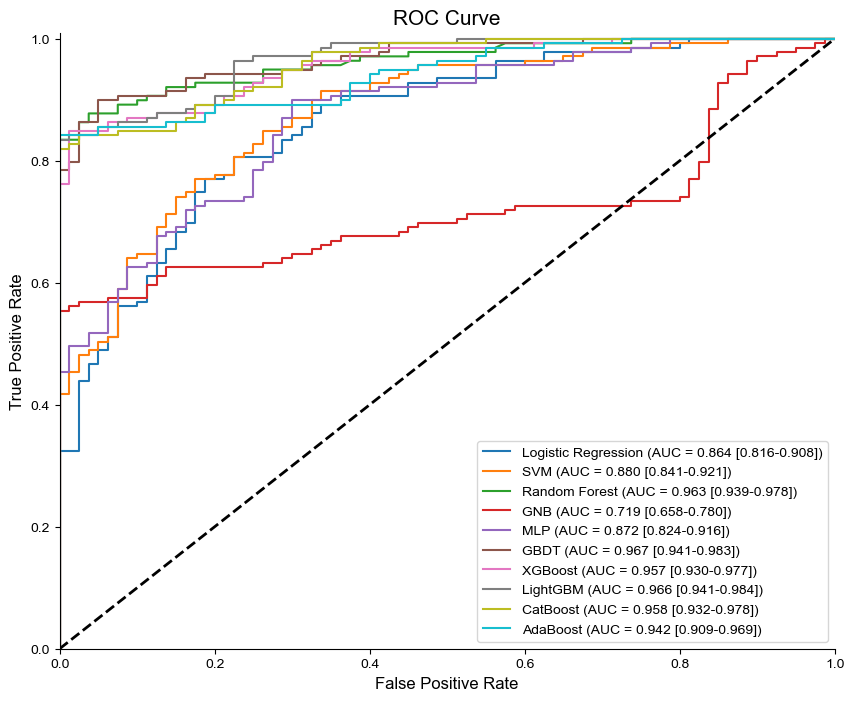

                 Model                  AUC             Accuracy  \
0  Logistic Regression  0.864 [0.816-0.908]  0.703 [0.630-0.753]   
1                  SVM  0.880 [0.841-0.921]  0.735 [0.543-0.653]   
2        Random Forest  0.963 [0.939-0.978]  0.868 [0.822-0.904]   
3                  GNB  0.719 [0.658-0.780]  0.703 [0.644-0.763]   
4                  MLP  0.872 [0.824-0.916]  0.721 [0.667-0.781]   
5                 GBDT  0.967 [0.941-0.983]  0.895 [0.840-0.922]   
6              XGBoost  0.957 [0.930-0.977]  0.863 [0.813-0.904]   
7             LightGBM  0.966 [0.941-0.984]  0.895 [0.845-0.936]   
8             CatBoost  0.958 [0.932-0.978]  0.836 [0.781-0.890]   
9             AdaBoost  0.942 [0.909-0.969]  0.890 [0.758-0.858]   

           Sensitivity          Specificity         Youden Index  \
0  0.597 [0.493-0.662]  0.887 [0.821-0.959]  0.485 [0.345-0.562]   
1  0.640 [0.301-0.445]  0.900 [1.000-1.000]  0.540 [0.301-0.445]   
2  0.791 [0.728-0.847]  1.000 [1.000-1.000]  0.

In [22]:
from sklearn.utils import resample
import numpy as np
import matplotlib.pyplot as plt
from sklearn.metrics import roc_auc_score, roc_curve, accuracy_score, recall_score, confusion_matrix, precision_score, f1_score, matthews_corrcoef
import pandas as pd

# 创建一个空的列表来存储每个模型的结果
results = []

plt.figure(figsize=(10, 8))  # 创建一个新的图形

# 外部验证测试
for name, model in best_models.items():
    # 计算模型的决策函数得分，如果没有 decision_function，则使用 predict_proba
    if hasattr(model, "decision_function"):
        y_score = model.decision_function(X_test)
    else:
        y_score = model.predict_proba(X_test)[:, 1]

    # 计算ROC曲线参数
    fpr, tpr, thresholds = roc_curve(y_test, y_score)
    auc = roc_auc_score(y_test, y_score)
    
    # 计算其他指标
    y_pred = model.predict(X_test)
    accuracy = accuracy_score(y_test, y_pred)
    sensitivity = recall_score(y_test, y_pred)
    tn, fp, fn, tp = confusion_matrix(y_test, y_pred).ravel()
    specificity = tn / (tn + fp)
    ppv = precision_score(y_test, y_pred)  # PPV
    npv = tn / (tn + fn)  # NPV
    f1 = f1_score(y_test, y_pred)  # F1 Score
    mcc = matthews_corrcoef(y_test, y_pred)  # MCC
    youden_index = sensitivity + specificity - 1
    
    # 使用自举法计算AUC和其他性能指标的95%置信区间
    n_bootstraps = 1000
    auc_scores, accuracy_scores, sensitivity_scores, specificity_scores = [], [], [], []
    ppv_scores, npv_scores, f1_scores, mcc_scores, youden_index_scores = [], [], [], [], []
    
    for _ in range(n_bootstraps):
        # 自举采样
        y_test_resampled, y_score_resampled = resample(y_test, y_score, random_state=np.random.randint(1, 100))
        auc_resampled = roc_auc_score(y_test_resampled, y_score_resampled)
        auc_scores.append(auc_resampled)

        # 根据新的y_test采样重新计算性能指标
        y_pred_resampled = np.where(y_score_resampled > 0.5, 1, 0)
        accuracy_scores.append(accuracy_score(y_test_resampled, y_pred_resampled))
        sensitivity_scores.append(recall_score(y_test_resampled, y_pred_resampled))
        tn_resampled, fp_resampled, fn_resampled, tp_resampled = confusion_matrix(y_test_resampled, y_pred_resampled).ravel()
        specificity_scores.append(tn_resampled / (tn_resampled + fp_resampled))
        ppv_scores.append(precision_score(y_test_resampled, y_pred_resampled))
        npv_scores.append(tn_resampled / (tn_resampled + fn_resampled))
        f1_scores.append(f1_score(y_test_resampled, y_pred_resampled))
        mcc_scores.append(matthews_corrcoef(y_test_resampled, y_pred_resampled))
        youden_index_scores.append(sensitivity_scores[-1] + specificity_scores[-1] - 1)
    
    # 计算各项指标的95%置信区间
    def compute_ci(scores):
        sorted_scores = np.array(scores)
        sorted_scores.sort()
        lower = sorted_scores[int(0.025 * len(sorted_scores))]
        upper = sorted_scores[int(0.975 * len(sorted_scores))]
        return lower, upper
    
    auc_ci = compute_ci(auc_scores)
    accuracy_ci = compute_ci(accuracy_scores)
    sensitivity_ci = compute_ci(sensitivity_scores)
    specificity_ci = compute_ci(specificity_scores)
    ppv_ci = compute_ci(ppv_scores)
    npv_ci = compute_ci(npv_scores)
    f1_ci = compute_ci(f1_scores)
    mcc_ci = compute_ci(mcc_scores)
    youden_index_ci = compute_ci(youden_index_scores)
    
    # 绘制ROC曲线
    plt.plot(fpr, tpr, label=f'{name} (AUC = {auc:.3f} [{auc_ci[0]:.3f}-{auc_ci[1]:.3f}])')

    # 存储每个模型的结果，包括置信区间
    results.append({
        'Model': name,
        'AUC': f'{auc:.3f} [{auc_ci[0]:.3f}-{auc_ci[1]:.3f}]',
        'Accuracy': f'{accuracy:.3f} [{accuracy_ci[0]:.3f}-{accuracy_ci[1]:.3f}]',
        'Sensitivity': f'{sensitivity:.3f} [{sensitivity_ci[0]:.3f}-{sensitivity_ci[1]:.3f}]',
        'Specificity': f'{specificity:.3f} [{specificity_ci[0]:.3f}-{specificity_ci[1]:.3f}]',
        'Youden Index': f'{youden_index:.3f} [{youden_index_ci[0]:.3f}-{youden_index_ci[1]:.3f}]',
        'PPV': f'{ppv:.3f} [{ppv_ci[0]:.3f}-{ppv_ci[1]:.3f}]',
        'NPV': f'{npv:.3f} [{npv_ci[0]:.3f}-{npv_ci[1]:.3f}]',
        'F1 Score': f'{f1:.3f} [{f1_ci[0]:.3f}-{f1_ci[1]:.3f}]',
        'MCC': f'{mcc:.3f} [{mcc_ci[0]:.3f}-{mcc_ci[1]:.3f}]'
    })

# 绘制随机猜测线
plt.plot([0, 1], [0, 1], 'k--', lw=2)
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.01])

# 添加标签和图例
plt.xlabel('False Positive Rate', fontsize=12)
plt.ylabel('True Positive Rate', fontsize=12)
plt.title('ROC Curve', fontsize=15)
plt.legend(loc="lower right")

# 移除右边和上边边界
plt.gca().spines['right'].set_visible(False)
plt.gca().spines['top'].set_visible(False)

# 保存ROC曲线为矢量图
plt.savefig(result_path + '482rna外部测试ROC.svg', format='svg')

# 显示绘图
plt.show()

# 将结果转换为DataFrame并显示
results_df = pd.DataFrame(results)
print(results_df)

# 将结果数据框保存为CSV文件
results_df.to_csv(result_path + '482rna_results.csv', index=False)


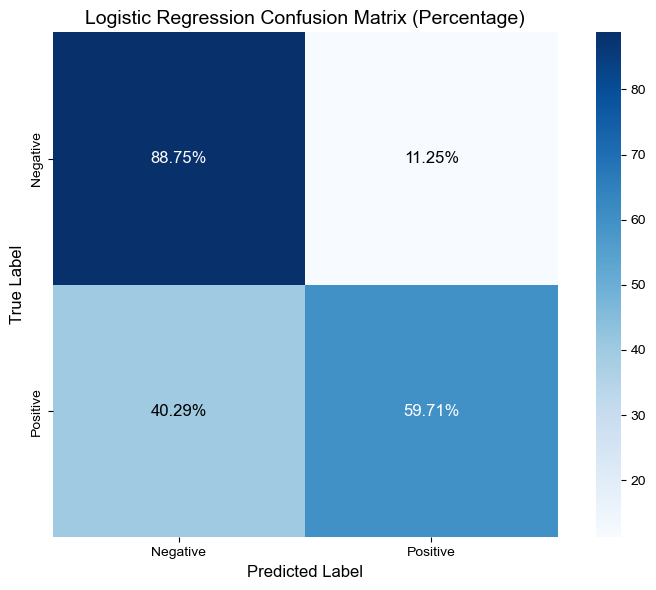

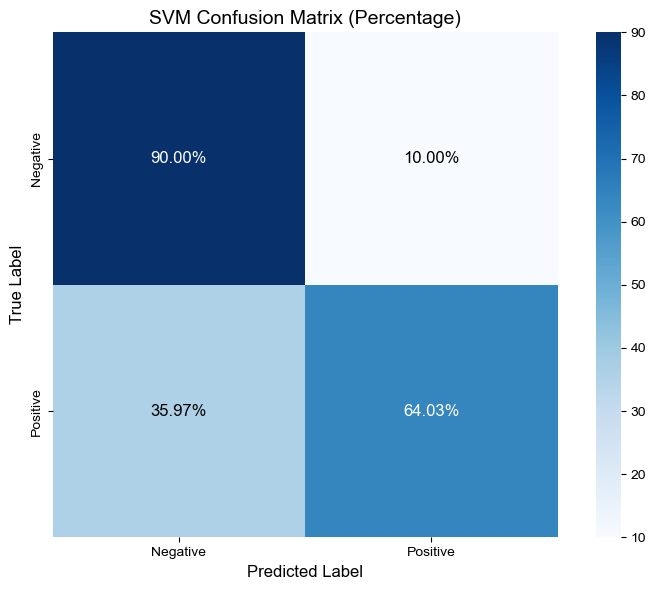

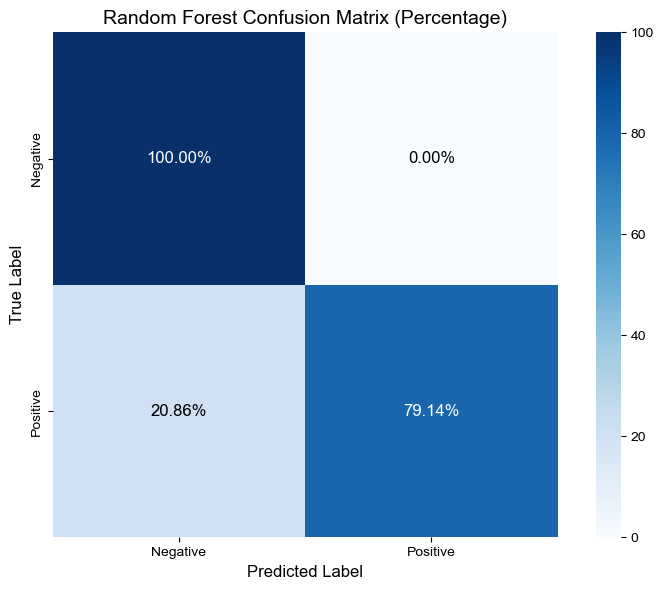

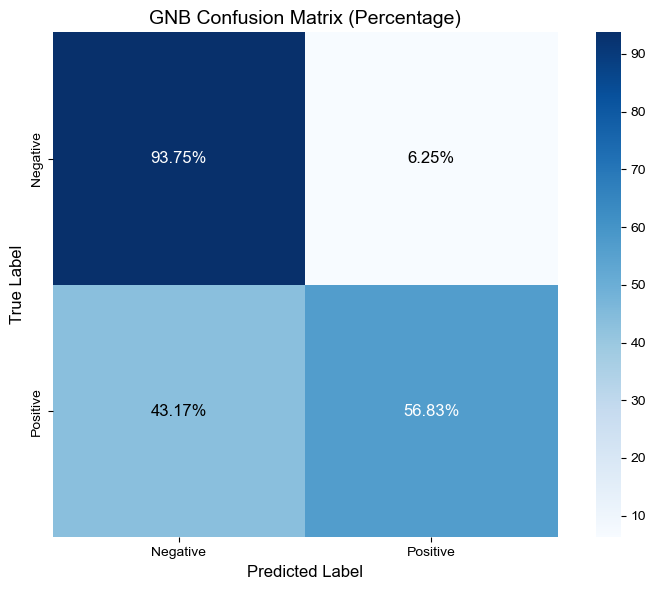

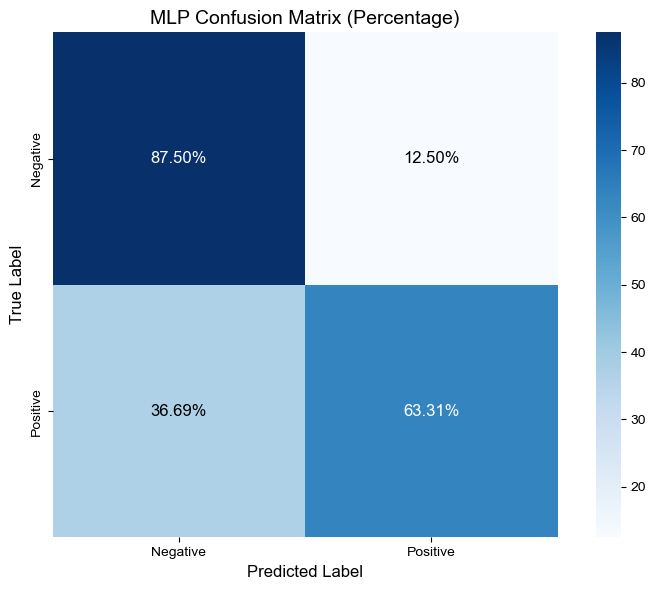

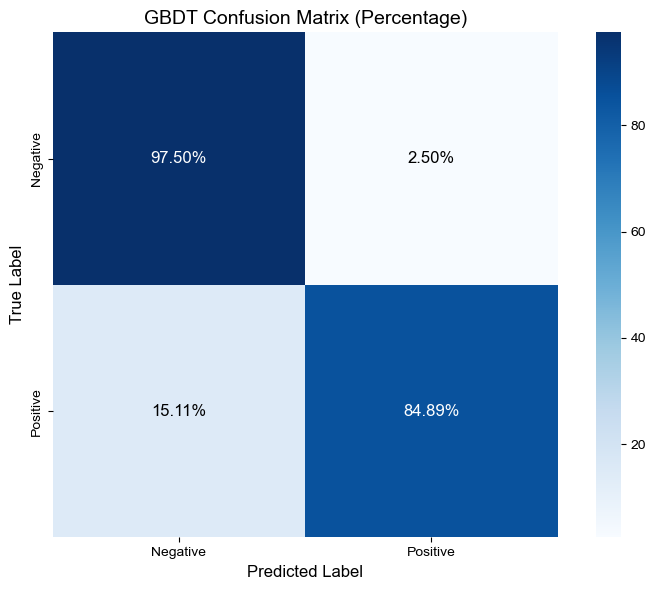

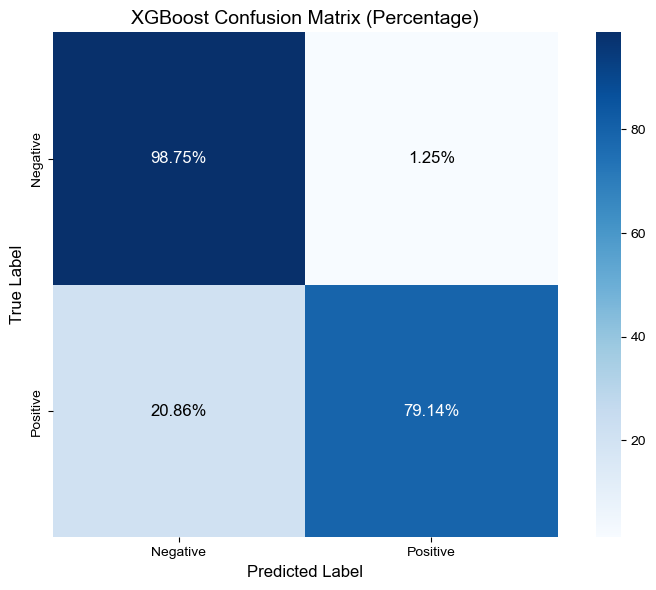

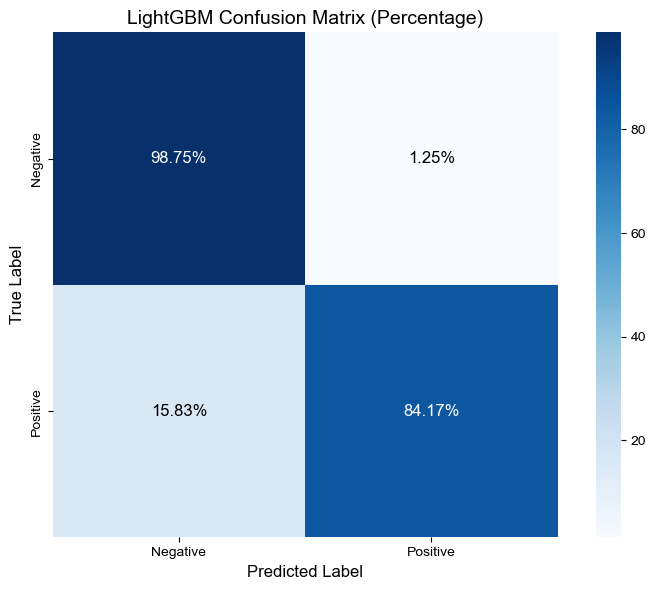

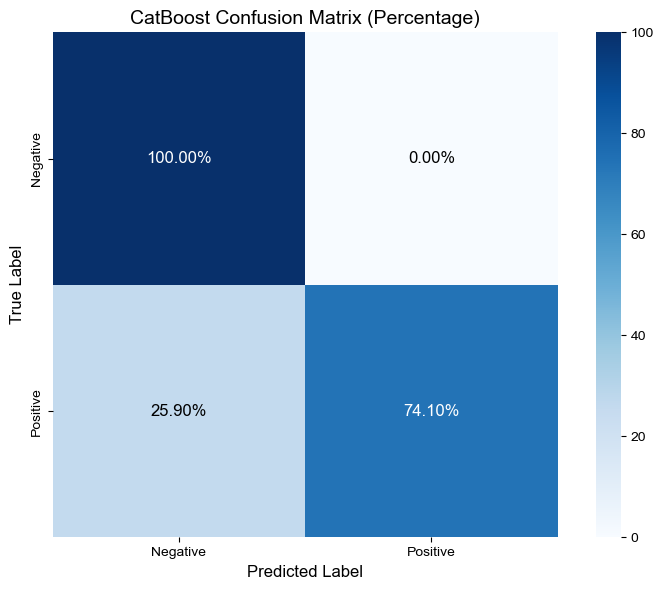

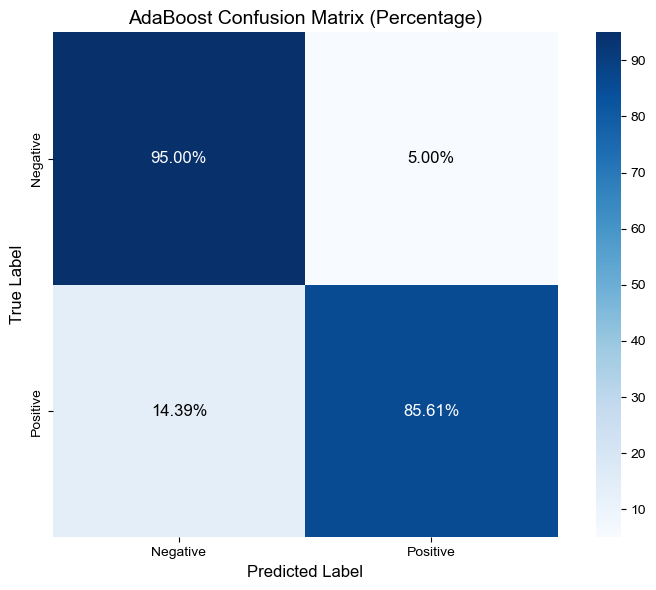

In [23]:
import seaborn as sns
from sklearn.metrics import confusion_matrix
import matplotlib.pyplot as plt
import numpy as np

# 遍历每个模型，绘制混淆矩阵
for name, model in best_models.items():
    # 使用最佳模型进行预测
    y_test_pred = model.predict(X_test)
    
    # 计算混淆矩阵
    cm = confusion_matrix(y_test, y_test_pred)
    
    # 将混淆矩阵数值转换为百分比
    cm_percentage = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis] * 100
    
    # 创建一个图形
    plt.figure(figsize=(8, 6))
    
    # 使用Seaborn的heatmap绘制混淆矩阵，数值用百分数表示
    sns.heatmap(cm_percentage, annot=False, fmt=".2f", cmap='Blues', cbar=True, square=True,
                xticklabels=['Negative', 'Positive'], 
                yticklabels=['Negative', 'Positive'])
    
    # 添加数字到热图上，使用反色
    for i in range(cm_percentage.shape[0]):
        for j in range(cm_percentage.shape[1]):
            # 根据百分比值设置文本颜色
            color = 'black' if cm_percentage[i, j] < 50 else 'white'
            plt.text(j + 0.5, i + 0.5, f"{cm_percentage[i, j]:.2f}%", 
                     ha='center', va='center', color=color, fontsize=12)
    
    # 添加标题和标签
    plt.title(f'{name} Confusion Matrix (Percentage)', fontsize=14)
    plt.xlabel('Predicted Label', fontsize=12)
    plt.ylabel('True Label', fontsize=12)
    
    # 显示混淆矩阵
    plt.tight_layout()
    
    # 保存为文件
    plt.savefig(f'{result_path}{name}_confusion_matrix.svg', format='svg')
    
    # 显示图像
    plt.show()



In [24]:
import joblib

# 保存每个最佳模型
for name, model in best_models.items():
    joblib.dump(model, f'{result_path}/model/{name}_model.pkl')
    print(f"{name} model saved successfully.")

Logistic Regression model saved successfully.
SVM model saved successfully.
Random Forest model saved successfully.
GNB model saved successfully.
MLP model saved successfully.
GBDT model saved successfully.
XGBoost model saved successfully.
LightGBM model saved successfully.
CatBoost model saved successfully.
AdaBoost model saved successfully.


In [17]:
# 更新后
import shap
import pandas as pd

# 初始化结果存储目录
output_dir = result_path

# 特征数量
num_features = X_test.shape[1]
max_evals = 2 * num_features + 1

# 存储所有模型的 SHAP 值
shap_values_dict = {}

# 逐一处理每个模型并保存 SHAP 值为 CSV 文件
for name, model in best_models.items():
    print(f"Processing SHAP for {name}...")
    
    # 创建 SHAP 解释器
    if hasattr(model, "predict_proba"):
        explainer = shap.Explainer(model.predict_proba, df_feature)
    else:
        explainer = shap.Explainer(model.predict, df_feature)

    # 计算 SHAP 值
    shap_values = explainer(X_test, max_evals=max_evals)

    # 如果是二分类模型，选择 SHAP 值中的正类（假设类别 1）
    if len(shap_values.values.shape) == 3:
        shap_values_selected = shap_values[..., 1]  # 提取正类的 SHAP 值
    else:
        shap_values_selected = shap_values  # 对于其他模型直接使用

    # 保存 SHAP 值到字典
    shap_values_dict[name] = shap_values_selected

    # 保存 SHAP 值为 CSV 文件
    output_path_csv = f'{output_dir}allrna_{name}_shap_values.csv'
    pd.DataFrame(shap_values_selected.values, columns=X_test.columns).to_csv(output_path_csv, index=False)
    print(f"SHAP values for {name} saved to {output_path_csv}")


    # 绘制 SHAP 摘要图
    plt.figure()
    shap.summary_plot(shap_values_selected, X_test, max_display=20, show=False)

    # 保存 SHAP 图为 SVG 格式
    output_path_plot = f'{output_dir}allrna_{name}_shap.svg'
    plt.savefig(output_path_plot, format='svg')
    plt.close()
    print(f"SHAP plot for {name} saved to {output_path_plot}")


Processing SHAP for Logistic Regression...


PermutationExplainer explainer: 227it [01:14,  2.69it/s]                         


SHAP values for Logistic Regression saved to C:/Users/74101/Desktop/成人抑郁症/result/10.16/other/allrna_Logistic Regression_shap_values.csv
SHAP plot for Logistic Regression saved to C:/Users/74101/Desktop/成人抑郁症/result/10.16/other/allrna_Logistic Regression_shap.svg
Processing SHAP for SVM...


PermutationExplainer explainer: 227it [16:30,  4.46s/it]                         


SHAP values for SVM saved to C:/Users/74101/Desktop/成人抑郁症/result/10.16/other/allrna_SVM_shap_values.csv
SHAP plot for SVM saved to C:/Users/74101/Desktop/成人抑郁症/result/10.16/other/allrna_SVM_shap.svg
Processing SHAP for Random Forest...


PermutationExplainer explainer: 227it [03:38,  1.01s/it]                         


SHAP values for Random Forest saved to C:/Users/74101/Desktop/成人抑郁症/result/10.16/other/allrna_Random Forest_shap_values.csv
SHAP plot for Random Forest saved to C:/Users/74101/Desktop/成人抑郁症/result/10.16/other/allrna_Random Forest_shap.svg
Processing SHAP for GNB...


PermutationExplainer explainer: 227it [05:33,  1.52s/it]                         


SHAP values for GNB saved to C:/Users/74101/Desktop/成人抑郁症/result/10.16/other/allrna_GNB_shap_values.csv
SHAP plot for GNB saved to C:/Users/74101/Desktop/成人抑郁症/result/10.16/other/allrna_GNB_shap.svg
Processing SHAP for MLP...


PermutationExplainer explainer: 227it [01:49,  1.87it/s]                         


SHAP values for MLP saved to C:/Users/74101/Desktop/成人抑郁症/result/10.16/other/allrna_MLP_shap_values.csv
SHAP plot for MLP saved to C:/Users/74101/Desktop/成人抑郁症/result/10.16/other/allrna_MLP_shap.svg
Processing SHAP for GBDT...


PermutationExplainer explainer: 227it [04:15,  1.17s/it]                         


SHAP values for GBDT saved to C:/Users/74101/Desktop/成人抑郁症/result/10.16/other/allrna_GBDT_shap_values.csv
SHAP plot for GBDT saved to C:/Users/74101/Desktop/成人抑郁症/result/10.16/other/allrna_GBDT_shap.svg
Processing SHAP for XGBoost...


PermutationExplainer explainer: 227it [01:35,  2.14it/s]                         


SHAP values for XGBoost saved to C:/Users/74101/Desktop/成人抑郁症/result/10.16/other/allrna_XGBoost_shap_values.csv
SHAP plot for XGBoost saved to C:/Users/74101/Desktop/成人抑郁症/result/10.16/other/allrna_XGBoost_shap.svg
Processing SHAP for LightGBM...


PermutationExplainer explainer: 227it [01:28,  2.28it/s]                         


SHAP values for LightGBM saved to C:/Users/74101/Desktop/成人抑郁症/result/10.16/other/allrna_LightGBM_shap_values.csv
SHAP plot for LightGBM saved to C:/Users/74101/Desktop/成人抑郁症/result/10.16/other/allrna_LightGBM_shap.svg
Processing SHAP for CatBoost...


PermutationExplainer explainer: 227it [04:04,  1.15s/it]                         


SHAP values for CatBoost saved to C:/Users/74101/Desktop/成人抑郁症/result/10.16/other/allrna_CatBoost_shap_values.csv
SHAP plot for CatBoost saved to C:/Users/74101/Desktop/成人抑郁症/result/10.16/other/allrna_CatBoost_shap.svg
Processing SHAP for AdaBoost...


PermutationExplainer explainer: 227it [1:50:39, 29.38s/it]                         


SHAP values for AdaBoost saved to C:/Users/74101/Desktop/成人抑郁症/result/10.16/other/allrna_AdaBoost_shap_values.csv
SHAP plot for AdaBoost saved to C:/Users/74101/Desktop/成人抑郁症/result/10.16/other/allrna_AdaBoost_shap.svg


# 90%

In [5]:
from collections import Counter
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import StratifiedKFold
import shap
import numpy as np
# 设置模型参数
params = {'max_depth': 30, 'min_samples_leaf': 1, 'min_samples_split': 2, 'n_estimators': 100}

# 交叉验证设置
cv = StratifiedKFold(n_splits=10, shuffle=True, random_state=42)

# 函数：标准化重要性
def normal_imp(mydict):
    mysum = sum(mydict.values())
    for key in mydict.keys():
        mydict[key] = mydict[key] / mysum
    return mydict

# 初始化重要性计数器
tg_imp_cv = Counter()
shap_imp_cv = np.zeros(df_feature.shape[1])  # 初始化SHAP重要性数组


# 交叉验证过程
for train_idx, test_idx in cv.split(df_feature, df_group):
    X_train, X_test = df_feature.iloc[train_idx, :], df_feature.iloc[test_idx, :]
    y_train, y_test = df_group.iloc[train_idx], df_group.iloc[test_idx]

    # 训练 GBDT 分类器
    my_rf = RandomForestClassifier(**params)
    my_rf.fit(X_train, y_train)

    # 计算总增益重要性
    totalgain_imp = my_rf.feature_importances_  # 直接使用 feature_importances_
    totalgain_imp = dict(zip(df_feature.columns, totalgain_imp.tolist()))

    # 计算总覆盖率重要性，GBDT没有办法计算
    # totalcover_imp = my_gbdt.booster_.feature_importance(importance_type='split')
    # totalcover_imp = dict(zip(df_feature.columns, totalcover_imp.tolist()))

    # 更新重要性计数器
    tg_imp_cv += Counter(normal_imp(totalgain_imp))

    # 计算 SHAP 值
    explainer = shap.TreeExplainer(my_rf)
    shap_values = explainer.shap_values(X_test)
    # 取绝对值的平均 SHAP 值，确保分母合理
    shap_values_mean = np.mean(np.abs(shap_values[:, :, 1]), axis=0)
    shap_imp_cv += shap_values_mean / np.sum(shap_values_mean)  # 归一化

In [6]:

# 创建 SHAP 重要性数据框
shap_imp_df = pd.DataFrame({
    'Analytes': df_feature.columns,
    'ShapValues_cv': shap_imp_cv / 10
})
shap_imp_df.sort_values(by='ShapValues_cv', ascending=False, inplace=True)

# 计算基本统计信息
stats_summary = {
    'Mean': shap_imp_df['ShapValues_cv'].mean(),
    'Std': shap_imp_df['ShapValues_cv'].std(),
    'Min': shap_imp_df['ShapValues_cv'].min(),
    'Max': shap_imp_df['ShapValues_cv'].max(),
    '25%': shap_imp_df['ShapValues_cv'].quantile(0.25),
    '50% (Median)': shap_imp_df['ShapValues_cv'].median(),
    '75%': shap_imp_df['ShapValues_cv'].quantile(0.75)
}

# 打印统计信息
print("SHAP Values CV Statistics:")
for stat, value in stats_summary.items():
    print(f"{stat}: {value:.4f}")

# 创建总增益重要性数据框
tg_imp_cv = normal_imp(tg_imp_cv)
tg_imp_df = pd.DataFrame({
    'Analytes': list(tg_imp_cv.keys()),
    'TotalGain_cv': list(tg_imp_cv.values())
})
tg_imp_df

SHAP Values CV Statistics:
Mean: 0.0012
Std: 0.0033
Min: 0.0000
Max: 0.0372
25%: 0.0002
50% (Median): 0.0003
75%: 0.0008


,Analytes,TotalGain_cv
0,hsa-let-7a-1_hsa-let-7a-3p,0.000243
1,hsa-let-7a-1_hsa-let-7a-5p,0.000115
2,hsa-let-7a-2_hsa-let-7a-5p,0.000056
3,hsa-let-7a-3_hsa-let-7a-3p,0.000774
4,hsa-let-7a-3_hsa-let-7a-5p,0.000075
...,...,...
818,hsa-mir-149_hsa-miR-149-5p,0.000058
819,tsrna_AACTTAACTTGACCGCTCTGACCA,0.000019
820,rsrna_GGTGGTGCATGGCCGTTCTT,0.000026
821,piR-hsa-168711,0.000037


In [7]:
# 合并所有重要性数据框
my_imp_df = pd.merge(left=shap_imp_df, right=tg_imp_df, how='left', on=['Analytes'])

# 计算综合重要性
my_imp_df['Ensemble_cv'] = (my_imp_df['ShapValues_cv'] + my_imp_df['TotalGain_cv']) / 2
my_imp_df.sort_values(by='TotalGain_cv', ascending=False, inplace=True)

# 保存结果
my_imp_df.to_csv(result_path + 'mdd_Importance483.csv', index=False)

print('finished')

finished


In [8]:
# 筛选前90%增益特征，不只使用TotalGain_cv，使用Ensemble_cv

def get_imp_analy(my_imp_df, top_prop=0.9):
    imp_score, iter = 0, 0
    # 遍历 my_imp_df 的 Ensemble_cv 列，累加直到累计超过 top_prop
    while imp_score < top_prop and iter < len(my_imp_df):  
        imp_score += my_imp_df.Ensemble_cv.iloc[iter]  # 使用 iloc 获取第 iter 行的值
        iter += 1
    return iter  # 返回累积达到 top_prop 时的行索引

# 调用函数，使用 Ensemble_cv
top_feature_count = get_imp_analy(my_imp_df, top_prop=0.9)

print(f"Number of proteins contributing to over 90% of overall information gains: {top_feature_count}")

# 获取前 top_feature_count 个特征
top_features = my_imp_df.iloc[:top_feature_count]

# 保存到 CSV 文件
top_features.to_csv(result_path + 'Top_90_InfoGain_features.csv', index=False)

print('Top-ranked proteins saved to CSV.')

Number of proteins contributing to over 90% of overall information gains: 314
Top-ranked proteins saved to CSV.


# 顺序向前筛选

In [ ]:
import numpy as np
import pandas as pd
import scipy.stats
from sklearn.ensemble import GradientBoostingClassifier
import lightgbm as lgb
from sklearn.model_selection import StratifiedKFold
from sklearn.metrics import roc_auc_score
import pandas as pd
import numpy as np
import scipy.stats
from scipy.stats import norm
from scipy import stats


# AUC comparison adapted from
def compute_midrank(x):
    """Computes midranks."""
    J = np.argsort(x)
    Z = x[J]
    N = len(x)
    T = np.zeros(N, dtype=float)
    i = 0
    while i < N:
        j = i
        while j < N and Z[j] == Z[i]:
            j += 1
        T[i:j] = 0.5 * (i + j - 1)
        i = j
    T2 = np.empty(N, dtype=float)
    T2[J] = T + 1
    return T2


def fastDeLong(predictions_sorted_transposed, label_1_count):
    """
    The fast version of DeLong's method for computing the covariance of
    unadjusted AUC.
    Args:
       predictions_sorted_transposed: a 2D numpy.array[n_classifiers, n_examples]
          sorted such as the examples with label "1" are first
    Returns:
       (AUC value, DeLong covariance)
    Reference:
     @article{sun2014fast,
       title={Fast Implementation of DeLong's Algorithm for
              Comparing the Areas Under Correlated Receiver Operating Characteristic Curves},
       author={Xu Sun and Weichao Xu},
       journal={IEEE Signal Processing Letters},
       volume={21},
       number={11},
       pages={1389--1393},
       year={2014},
       publisher={IEEE}
     }
    """
    # Short variables are named as they are in the paper
    m = label_1_count
    n = predictions_sorted_transposed.shape[1] - m
    positive_examples = predictions_sorted_transposed[:, :m]
    negative_examples = predictions_sorted_transposed[:, m:]
    k = predictions_sorted_transposed.shape[0]

    tx = np.empty([k, m], dtype=float)
    ty = np.empty([k, n], dtype=float)
    tz = np.empty([k, m + n], dtype=float)
    for r in range(k):
        tx[r, :] = compute_midrank(positive_examples[r, :])
        ty[r, :] = compute_midrank(negative_examples[r, :])
        tz[r, :] = compute_midrank(predictions_sorted_transposed[r, :])
    aucs = tz[:, :m].sum(axis=1) / m / n - float(m + 1.0) / 2.0 / n
    v01 = (tz[:, :m] - tx[:, :]) / n
    v10 = 1.0 - (tz[:, m:] - ty[:, :]) / m
    sx = np.cov(v01)
    sy = np.cov(v10)
    delongcov = sx / m + sy / n
    return aucs, delongcov


def calc_pvalue(aucs, covar):
    """Computes log(10) of p-values.
    Args:
       aucs: 1D array of AUCs
       covar: AUC DeLong covariances
    Returns:
       log10(pvalue)
    """
    l = np.array([[1, -1]])
    z = np.abs(np.diff(aucs)) / np.sqrt(np.dot(np.dot(l, covar), l.T))  # 将 sigma 改为 covar
    return np.log10(2) + scipy.stats.norm.logsf(z, loc=0, scale=1) / np.log(10)


def compute_ground_truth_statistics(ground_truth):
    assert np.array_equal(np.unique(ground_truth), [0, 1])
    order = (-ground_truth).argsort()
    label_1_count = int(ground_truth.sum())
    return order, label_1_count


def delong_roc_variance(ground_truth, predictions):
    """
    Computes ROC AUC variance for a single set of predictions
    Args:
       ground_truth: np.array of 0 and 1
       predictions: np.array of floats of the probability of being class 1
    """
    order, label_1_count = compute_ground_truth_statistics(ground_truth)
    predictions_sorted_transposed = predictions[np.newaxis, order]
    aucs, delongcov = fastDeLong(predictions_sorted_transposed, label_1_count)
    assert len(aucs) == 1, "There is a bug in the code, please forward this to the developers"
    return aucs[0], delongcov


def delong_roc_test(ground_truth, predictions_one, predictions_two):
    """
    Computes log(p-value) for hypothesis that two ROC AUCs are different
    Args:
       ground_truth: np.array of 0 and 1
       predictions_one: predictions of the first model,
          np.array of floats of the probability of being class 1
       predictions_two: predictions of the second model,
          np.array of floats of the probability of being class 1
    """
    order, label_1_count = compute_ground_truth_statistics(ground_truth)
    predictions_sorted_transposed = np.vstack((predictions_one, predictions_two))[:, order]
    aucs, delongcov = fastDeLong(predictions_sorted_transposed, label_1_count)
    return calc_pvalue(aucs, delongcov)


# ImpMethod = 'Ensemble'

# 同上，加不加载都行
# 使用筛选出的特征来过滤训练集特征
top_features_df = pd.read_csv(result_path + 'Top_90_InfoGain_features.csv')
top_features = top_features_df['Analytes'].tolist()
feature_90 = train_df_filtered[top_features]


# 设置模型参数
params = {'max_depth': 30, 'min_samples_leaf': 1, 'min_samples_split': 2, 'n_estimators': 100}

# 初始化交叉验证器
cv = StratifiedKFold(n_splits=10, shuffle=True, random_state=42)

# 初始化前向选择的变量
y_pred_lst_prev1 = np.zeros(len(df_group))
y_pred_lst_prev2 = np.zeros(len(df_group))
y_pred_lst_prev3 = np.zeros(len(df_group))
tmp_f, AUC_cv_lst = [], []


# 顺序前向选择的过程
for f in top_features:  # 遍历所有筛选出的特征
    tmp_f.append(f)  # 依次添加一个特征
    my_X = feature_90[tmp_f]  # 选择当前的特征集合
    
    AUC_cv, y_pred_lst, y_true_lst = [], [], []
    
    # 交叉验证
    for train_idx, test_idx in cv.split(my_X, df_group):
        X_train, X_test = my_X.iloc[train_idx, :], my_X.iloc[test_idx, :]
        y_train, y_test = df_group.iloc[train_idx], df_group.iloc[test_idx]
        
        # 训练GBDT模型
        my_gbdt = RandomForestClassifier(**params)
        my_gbdt.fit(X_train, y_train)
        
        # 预测概率
        y_pred_prob = my_gbdt.predict_proba(X_test)[:, 1]
        AUC_cv.append(roc_auc_score(y_test, y_pred_prob))  # 计算AUC
        
        y_pred_lst += y_pred_prob.tolist()
        y_true_lst += y_test.tolist()
    
    # 计算整体的AUC
    auc_full = roc_auc_score(y_true_lst, y_pred_lst)
    
    # Delong检验：评估新特征的显著性提升
    log10_p1 = delong_roc_test(np.array(y_true_lst), np.array(y_pred_lst_prev1), np.array(y_pred_lst))
    log10_p2 = delong_roc_test(np.array(y_true_lst), np.array(y_pred_lst_prev2), np.array(y_pred_lst))
    log10_p3 = delong_roc_test(np.array(y_true_lst), np.array(y_pred_lst_prev3), np.array(y_pred_lst))
    
    print(f"Feature: {f}, Delong p-values: {log10_p1}, {log10_p2}, {log10_p3}")
    
    # 更新前一轮预测结果
    y_pred_lst_prev3 = y_pred_lst_prev2
    y_pred_lst_prev2 = y_pred_lst_prev1
    y_pred_lst_prev1 = y_pred_lst
    
    
    tmp_out = np.array([np.mean(AUC_cv), np.std(AUC_cv), 10**log10_p1[0][0], 10**log10_p2[0][0], 10**log10_p3[0][0], auc_full])
    AUC_cv_lst.append(tmp_out)
    print(f"Feature: {f}, AUC Results: {tmp_out}")
    
    # 输出当前特征集的AUC结果和显著性检验结果
    # tmp_out = np.array([np.mean(AUC_cv), np.std(AUC_cv), 10**log10_p1, 10**log10_p2, 10**log10_p3, auc_full])
    print(f"Feature: {f}, AUC Results: {tmp_out}")

# 创建结果DataFrame
AUC_df = pd.DataFrame(AUC_cv_lst, columns=['AUC_mean', 'AUC_std', 'Delong1', 'Delong2', 'Delong3', 'AUC_all'])
AUC_df[['AUC_mean', 'AUC_std', 'AUC_all']] = np.round(AUC_df[['AUC_mean', 'AUC_std', 'AUC_all']], 3)

# 添加特征名称
AUC_df = pd.concat((pd.DataFrame({'Analytes': tmp_f}), AUC_df), axis=1)

# 保存到CSV文件
AUC_df.to_csv(result_path + 'Delong_Selection_Results.csv', index=False)

print('Finished feature selection and saved results.')

Feature: rsrna_GACCAAGGAGTCTAACACGTGCGCG, Delong p-values: [[-671.76768024]], [[-671.76768024]], [[-671.76768024]]
Feature: rsrna_GACCAAGGAGTCTAACACGTGCGCG, AUC Results: [0.96444563 0.02424904 0.         0.         0.         0.9604487 ]
Feature: rsrna_GACCAAGGAGTCTAACACGTGCGCG, AUC Results: [0.96444563 0.02424904 0.         0.         0.         0.9604487 ]
Feature: rsrna_CAAGGAGTCTAACACGTGCGCG, Delong p-values: [[-0.57565241]], [[-756.89986712]], [[-756.89986712]]
Feature: rsrna_CAAGGAGTCTAACACGTGCGCG, AUC Results: [0.96765115 0.02091681 0.26567311 0.         0.         0.96380755]
Feature: rsrna_CAAGGAGTCTAACACGTGCGCG, AUC Results: [0.96765115 0.02091681 0.26567311 0.         0.         0.96380755]
Feature: rsrna_CTGGCACGGTGAAGAGACATGAGAGGTGTAGAATA, Delong p-values: [[-0.76577109]], [[-1.30628274]], [[-895.16446137]]
Feature: rsrna_CTGGCACGGTGAAGAGACATGAGAGGTGTAGAATA, AUC Results: [0.97187174 0.01485901 0.1714861  0.0493989  0.         0.96812022]
Feature: rsrna_CTGGCACGGTGAAGAGACAT

In [11]:
imp_df = pd.read_csv(result_path + 'Top_90_InfoGain_features.csv', usecols = ['Analytes', 'Ensemble_cv'])
imp_df.rename(columns = {'Ensemble_cv': 'sRNA_imp'}, inplace = True)
AUC_df = pd.read_csv(result_path + 'Delong_Selection_Results.csv')
mydf = pd.merge(AUC_df, imp_df, how = 'left', on = ['Analytes'])

C:\Users\74101\AppData\Local\Temp\ipykernel_41828\3924577608.py:11: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  mydf['AUC_upper'].iloc[mydf['AUC_upper']>=1] = 1


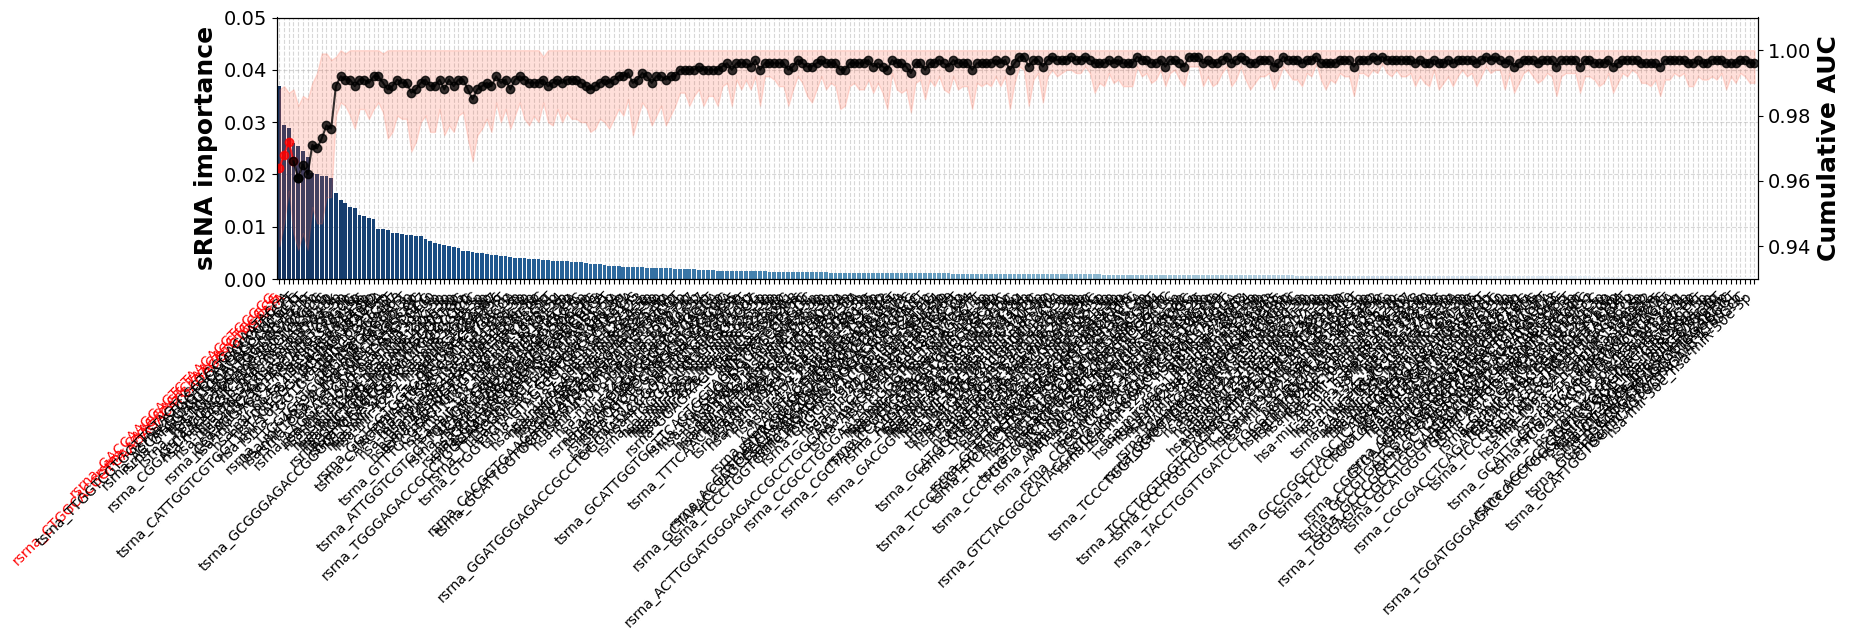

In [12]:
def get_nb_f(mydf):
    p_lst = mydf.Delong2.tolist()
    i = 0
    while((p_lst[i]<0.05)|(p_lst[i+1]<0.05)):
        i+=1
    return i

# 计算AUC的上下限
mydf['AUC_lower'] = mydf['AUC_mean'] - mydf['AUC_std']
mydf['AUC_upper'] = mydf['AUC_mean'] + mydf['AUC_std']
mydf['AUC_upper'].iloc[mydf['AUC_upper']>=1] = 1
mydf['rna_idx'] = [i for i in range(1, len(mydf)+1)]
nb_f = get_nb_f(mydf)

fig, ax = plt.subplots(figsize = (18, 6.5))
palette = sns.color_palette("Blues",n_colors=len(mydf))
palette.reverse()
sns.barplot(ax=ax, x = "Analytes", y = "sRNA_imp", palette=palette, data=mydf.sort_values(by="sRNA_imp", ascending=False))
y_imp_up_lim = round(mydf['sRNA_imp'].max() + 0.01, 2)
ax.set_ylim([0, y_imp_up_lim])
ax.tick_params(axis='y', labelsize=14)
ax.set_xticklabels(mydf['Analytes'], rotation=45, fontsize=10, horizontalalignment='right')
my_col = ['r']*nb_f + ['k']*(len(mydf)-nb_f)
for ticklabel, tickcolor in zip(plt.gca().get_xticklabels(), my_col):
    ticklabel.set_color(tickcolor)
    
ax.set_ylabel('sRNA importance', weight='bold', fontsize=18)
#ax.set_title(my_title, y=1.0, pad=-25, weight='bold', fontsize=24)
ax.set_xlabel('')
ax.grid(which='minor', alpha=0.2, linestyle=':')
ax.grid(which='major', alpha=0.5,  linestyle='--')
ax.set_axisbelow(True)

ax2 = ax.twinx()
ax2.plot(np.arange(nb_f+1), mydf['AUC_mean'][:nb_f+1], 'red', alpha = 0.8, marker='o')
ax2.plot(np.arange(nb_f+1, len(mydf)), mydf['AUC_mean'][nb_f+1:], 'black', alpha = 0.8, marker='o')
ax2.plot([nb_f, nb_f+1], mydf['AUC_mean'][nb_f:nb_f+2], 'black', alpha = 0.8, marker='o')
plt.fill_between(mydf['rna_idx']-1, mydf['AUC_lower'], mydf['AUC_upper'], color = 'tomato', alpha = 0.2)
ax2.set_ylabel('Cumulative AUC', weight='bold', fontsize=18)
ax2.tick_params(axis='y', labelsize=14)
y_auc_up_lim = round(mydf['AUC_upper'].max() + 0.01, 2)
y_auc_low_lim = round(mydf['AUC_lower'].min() - 0.01, 2)
ax2.set_ylim([y_auc_low_lim, y_auc_up_lim])


fig.tight_layout()
plt.xlim([-.6, len(mydf)-.2])
plt.savefig(result_path + 'Delong_Selection_Plot.svg', dpi=300, format='svg')
plt.show()

No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


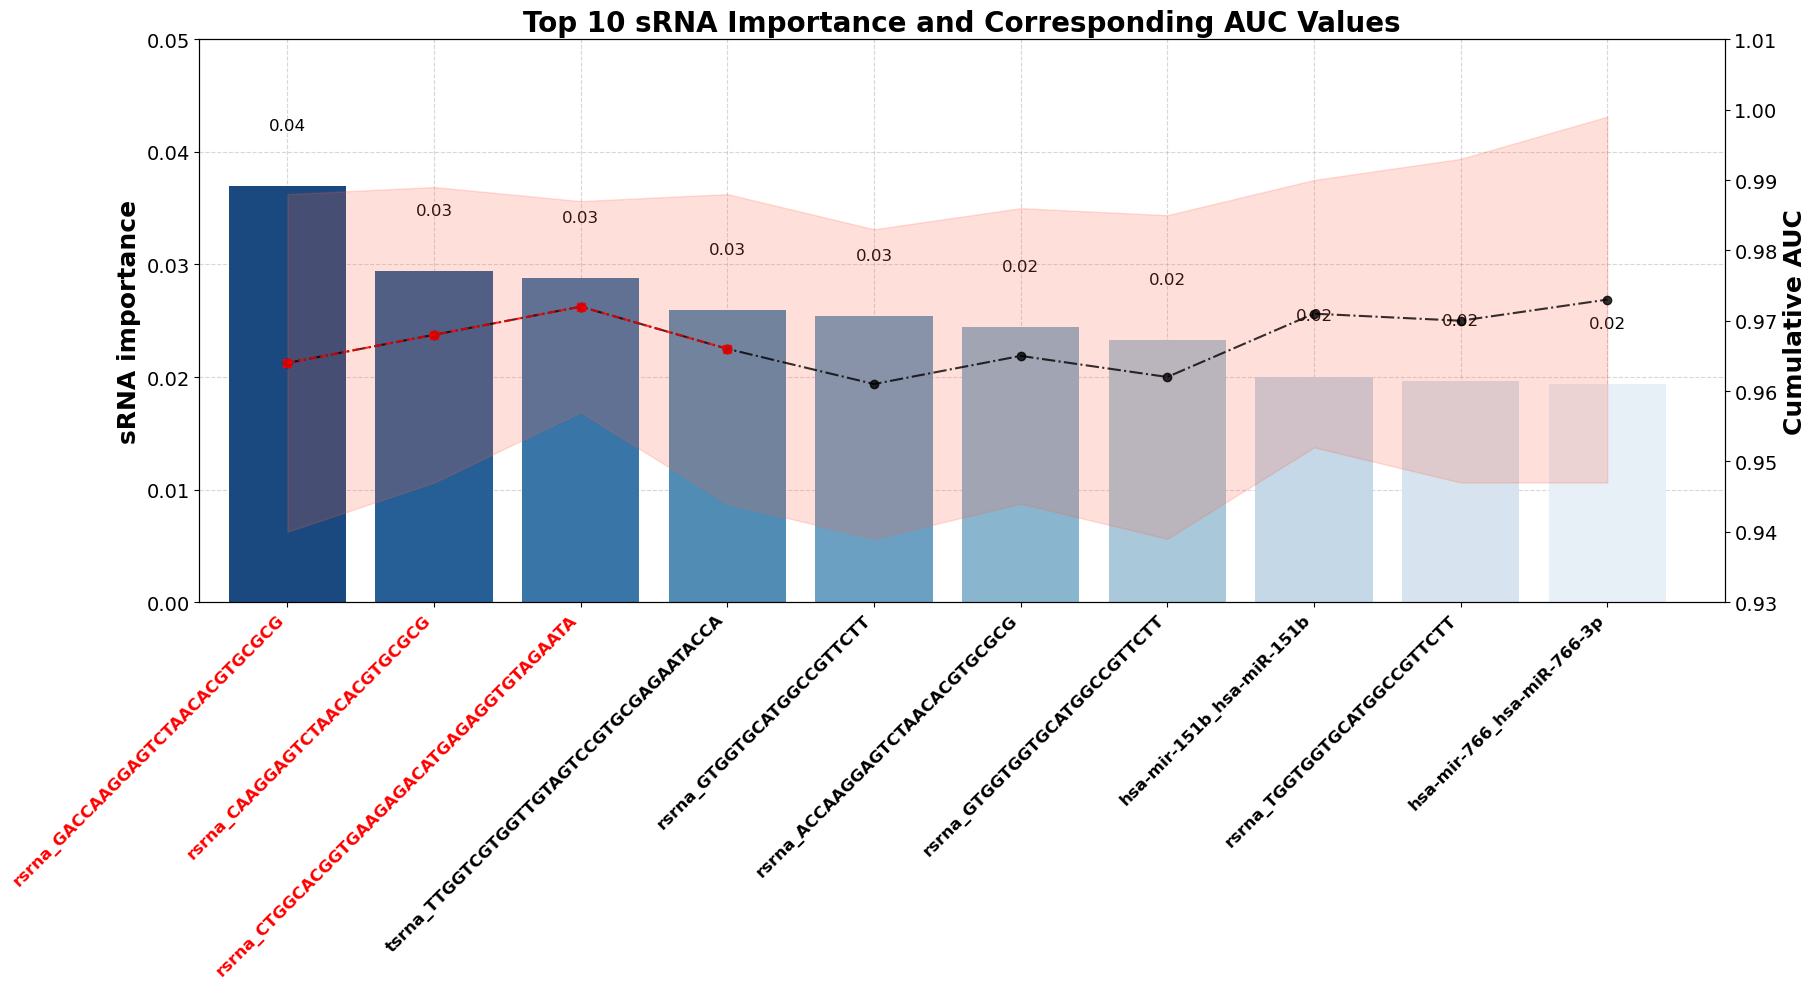

In [13]:
# 获取前十个数据
mydf_top10 = mydf[:10]

nb_f = get_nb_f(mydf_top10)

fig, ax = plt.subplots(figsize=(18, 10))
palette = sns.color_palette("Blues", n_colors=len(mydf_top10))
palette.reverse()
sns.barplot(ax=ax, x="Analytes", y="sRNA_imp", palette=palette, data=mydf_top10.sort_values(by="sRNA_imp", ascending=False))

# 设置柱子顶部显示数值
for i, val in enumerate(mydf_top10.sort_values(by="sRNA_imp", ascending=False)['sRNA_imp']):
    ax.text(i, val + 0.005, f'{val:.2f}', ha='center', fontsize=12)

y_imp_up_lim = round(mydf_top10['sRNA_imp'].max() + 0.01, 2)
ax.set_ylim([0, y_imp_up_lim])
ax.tick_params(axis='y', labelsize=14)
ax.set_xticklabels(mydf_top10['Analytes'], rotation=45, fontsize=12, fontweight='bold', horizontalalignment='right')

my_col = ['r']*nb_f + ['k']*(len(mydf_top10) - nb_f)
for ticklabel, tickcolor in zip(plt.gca().get_xticklabels(), my_col):
    ticklabel.set_color(tickcolor)

ax.set_ylabel('sRNA importance', weight='bold', fontsize=18)
ax.set_xlabel('')
ax.grid(which='minor', alpha=0.2, linestyle=':')
ax.grid(which='major', alpha=0.5, linestyle='--')
ax.set_axisbelow(True)

# 绘制第二个 y 轴上的 AUC 曲线
ax2 = ax.twinx()

# 前部分：红线，前 nb_f+1 个数据点
x_values_top = np.arange(nb_f + 1)
y_values_top = mydf_top10['AUC_mean'][:nb_f + 1]

# 后部分：黑线，后续的数据点
x_values_other = np.arange(nb_f + 1, len(mydf_top10))
y_values_other = mydf_top10['AUC_mean'][nb_f + 1:]

# 合并前后部分，确保连接点之间有线
x_values_full = np.concatenate((x_values_top, x_values_other))
y_values_full = np.concatenate((y_values_top, y_values_other))

# 分别绘制红线和黑线部分
ax2.plot(x_values_full, y_values_full, color='black', alpha=0.8, marker='o', linestyle='-.')
ax2.plot(x_values_top, y_values_top, color='red', alpha=0.8, marker='s', linestyle='--')

# 填充AUC区间
plt.fill_between(mydf_top10['rna_idx'] - 1, mydf_top10['AUC_lower'], mydf_top10['AUC_upper'], color='tomato', alpha=0.2)

# 设置 y 轴
ax2.set_ylabel('Cumulative AUC', weight='bold', fontsize=18)
ax2.tick_params(axis='y', labelsize=14)
y_auc_up_lim = round(mydf_top10['AUC_upper'].max() + 0.01, 2)
y_auc_low_lim = round(mydf_top10['AUC_lower'].min() - 0.01, 2)
ax2.set_ylim([y_auc_low_lim, y_auc_up_lim])

# 图例设置
ax2.legend(loc='upper right', fontsize=12, frameon=False)

# 添加标题
plt.title('Top 10 sRNA Importance and Corresponding AUC Values', fontsize=20, weight='bold')

# 调整布局并保存图像
fig.tight_layout()
plt.xlim([-.6, len(mydf_top10) - .2])
plt.savefig(result_path + 'Delong_Selection_Plot_top10.svg', dpi=600, format='svg')
plt.show()


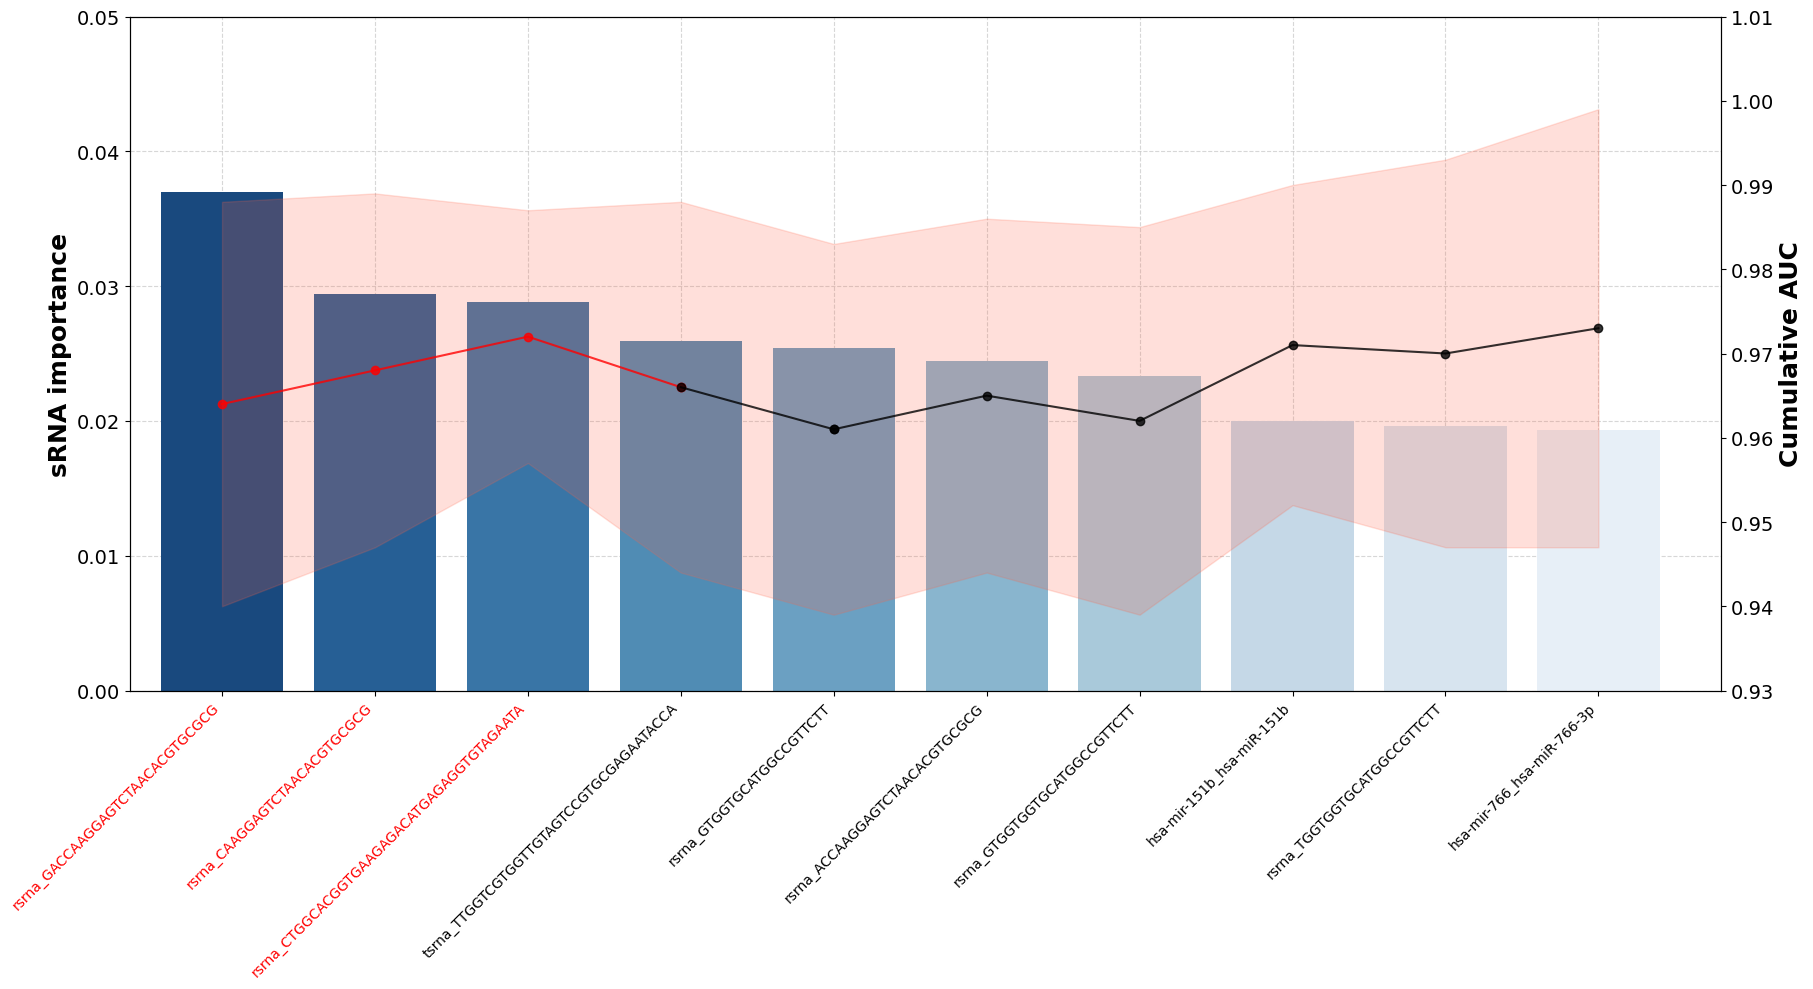

In [14]:
# 只绘制前十个

# 获取前十个数据
mydf_top10 = mydf[:10]

nb_f = get_nb_f(mydf_top10)

fig, ax = plt.subplots(figsize=(18, 10))
palette = sns.color_palette("Blues", n_colors=len(mydf_top10))
palette.reverse()
sns.barplot(ax=ax, x="Analytes", y="sRNA_imp", palette=palette, data=mydf_top10.sort_values(by="sRNA_imp", ascending=False))
y_imp_up_lim = round(mydf_top10['sRNA_imp'].max() + 0.01, 2)
ax.set_ylim([0, y_imp_up_lim])
ax.tick_params(axis='y', labelsize=14)
ax.set_xticklabels(mydf_top10['Analytes'], rotation=45, fontsize=10, horizontalalignment='right')

my_col = ['r']*nb_f + ['k']*(len(mydf_top10) - nb_f)
for ticklabel, tickcolor in zip(plt.gca().get_xticklabels(), my_col):
    ticklabel.set_color(tickcolor)

ax.set_ylabel('sRNA importance', weight='bold', fontsize=18)
ax.set_xlabel('')
ax.grid(which='minor', alpha=0.2, linestyle=':')
ax.grid(which='major', alpha=0.5, linestyle='--')
ax.set_axisbelow(True)

# 绘制第二个 y 轴上的 AUC 曲线
ax2 = ax.twinx()
ax2.plot(np.arange(nb_f+1), mydf_top10['AUC_mean'][:nb_f+1], 'red', alpha=0.8, marker='o')
ax2.plot(np.arange(nb_f+1, len(mydf_top10)), mydf_top10['AUC_mean'][nb_f+1:], 'black', alpha=0.8, marker='o')
ax2.plot([nb_f, nb_f+1], mydf_top10['AUC_mean'][nb_f:nb_f+2], 'black', alpha=0.8, marker='o')

# 填充AUC区间
plt.fill_between(mydf_top10['rna_idx']-1, mydf_top10['AUC_lower'], mydf_top10['AUC_upper'], color='tomato', alpha=0.2)
ax2.set_ylabel('Cumulative AUC', weight='bold', fontsize=18)
ax2.tick_params(axis='y', labelsize=14)
y_auc_up_lim = round(mydf_top10['AUC_upper'].max() + 0.01, 2)
y_auc_low_lim = round(mydf_top10['AUC_lower'].min() - 0.01, 2)
ax2.set_ylim([y_auc_low_lim, y_auc_up_lim])

# 调整布局并保存图像
fig.tight_layout()
plt.xlim([-.6, len(mydf_top10) - .2])
plt.savefig(result_path + 'Delong_Selection_Plot_top10.svg', dpi=300, format='svg')
plt.show()

In [88]:
mydf_top5 = mydf[:5]

In [98]:
mirna_group = df_group = train_df_filtered['group']
mirna_feature = df_feature = train_df_filtered[mydf['Analytes']]

In [99]:
# 定义模型的参数网格
param_grids = {
    'Logistic Regression': {
        'C': [0.01, 0.1, 1, 10, 100],
        'solver': ['saga'],
        'penalty': ['l2'],
        'max_iter': [10000]
    },
    'SVM': {
        'C': [0.1, 1, 10, 100],
        'kernel': ['rbf'],
        'gamma': ['scale', 'auto']
    },
    'Random Forest': {
        'n_estimators': [100, 200, 300],
        'max_depth': [None, 10, 20, 30],
        'min_samples_split': [2, 5, 10],
        'min_samples_leaf': [1, 2, 4]
    },
    'GNB': {
        'var_smoothing': [1e-9, 1e-8, 1e-7, 1e-6, 1e-5]
    },
    'MLP': {
        'hidden_layer_sizes': [(10,), (50,), (10, 50), (50, 50)],
        'activation': ['relu', 'tanh'],
        'solver': ['adam'],
        'alpha': [0.0001, 0.001, 0.01],
        'learning_rate': ['constant', 'adaptive']
    },
    'GBDT': {
        'n_estimators': [100, 200, 300],
        'learning_rate': [0.01, 0.1, 0.2],
        'max_depth': [3, 5, 7],
        'subsample': [0.7, 0.8, 1.0]
    },
    'XGBoost': {
        'n_estimators': [100, 200, 300],
        'learning_rate': [0.01, 0.1, 0.2],
        'max_depth': [3, 5, 7],
        'subsample': [0.7, 0.8, 1.0]
    },
    'LightGBM': {
        'n_estimators': [100, 200, 300],
        'learning_rate': [0.01, 0.1, 0.2],
        'num_leaves': [31, 50, 100],
        'boosting_type': ['gbdt'],
        'subsample': [0.7, 0.8, 1.0]
    },
    'CatBoost': {
        'iterations': [100, 200, 300],
        'learning_rate': [0.01, 0.1, 0.2],
        'depth': [3, 5, 7]
    },
    'AdaBoost': {
        'n_estimators': [50, 100, 200],
        'learning_rate': [0.01, 0.1, 1.0]
    }
}

# 定义模型
models = {
    'Logistic Regression': LogisticRegression(),
    'SVM': SVC(probability=True),
    'Random Forest': RandomForestClassifier(),
    'GNB': GaussianNB(),
    'MLP': MLPClassifier(),
    'GBDT': GradientBoostingClassifier(),
    'XGBoost': xgb.XGBClassifier(),
    'LightGBM': lgb.LGBMClassifier(),
    'CatBoost': CatBoostClassifier(verbose=0),
    'AdaBoost': AdaBoostClassifier()
}

# 交叉验证
cv = StratifiedKFold(n_splits=3, shuffle=True, random_state=42)

# 保存最优参数和模型
best_params = {}
best_models = {}

# 超参数优化
for model_name, model in models.items():
    if model_name in param_grids:
        param_grid = param_grids[model_name]
        grid_search = GridSearchCV(model, param_grid, cv=cv, scoring='roc_auc', n_jobs=-1)
        grid_search.fit(df_feature, df_group)
        best_params[model_name] = grid_search.best_params_
        best_models[model_name] = grid_search.best_estimator_
        print(f"Best parameters for {model_name}: {grid_search.best_params_}")
    else:
        model.fit(df_feature, df_group)
        best_models[model_name] = model
        print(f"{model_name} has no hyperparameters to tune.")

Best parameters for Logistic Regression: {'C': 1, 'max_iter': 10000, 'penalty': 'l2', 'solver': 'saga'}
Best parameters for SVM: {'C': 10, 'gamma': 'scale', 'kernel': 'rbf'}
Best parameters for Random Forest: {'max_depth': None, 'min_samples_leaf': 1, 'min_samples_split': 5, 'n_estimators': 100}
Best parameters for GNB: {'var_smoothing': 1e-09}


c:\Users\74101\Desktop\MCY-BI\conda\Lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:690: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  warnings.warn(


Best parameters for MLP: {'activation': 'relu', 'alpha': 0.0001, 'hidden_layer_sizes': (50, 50), 'learning_rate': 'adaptive', 'solver': 'adam'}
Best parameters for GBDT: {'learning_rate': 0.2, 'max_depth': 7, 'n_estimators': 300, 'subsample': 0.8}
Best parameters for XGBoost: {'learning_rate': 0.2, 'max_depth': 3, 'n_estimators': 200, 'subsample': 1.0}
[LightGBM] [Info] Number of positive: 202, number of negative: 413
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.000729 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 8711
[LightGBM] [Info] Number of data points in the train set: 615, number of used features: 46
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.328455 -> initscore=-0.715180
[LightGBM] [Info] Start training from score -0.715180
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightG

c:\Users\74101\Desktop\MCY-BI\conda\Lib\site-packages\sklearn\ensemble\_weight_boosting.py:527: FutureWarning: The SAMME.R algorithm (the default) is deprecated and will be removed in 1.6. Use the SAMME algorithm to circumvent this warning.
  warnings.warn(


Best parameters for AdaBoost: {'learning_rate': 1.0, 'n_estimators': 200}


In [100]:
# 保存最佳参数到文件
best_params_df = pd.DataFrame(list(best_params.items()), columns=['Model', 'Best Parameters'])
best_params_df['Best Parameters'] = best_params_df['Best Parameters'].apply(lambda x: str(x))  # 转换为字符串
best_params_df.to_csv(result_path + 'best_params.csv', index=False, encoding='utf-8-sig')

print("Best parameters saved to 'best_params.csv'")

# 扁平化字典
best_params_flat = {model: params for model, params in best_params.items()}
best_params_df = pd.json_normalize(best_params_flat).reset_index()
best_params_df.rename(columns={'index': 'Model'}, inplace=True)  # 重命名索引列为 'Model'
best_params_df.to_csv(result_path + 'best_params2.csv', index=False, encoding='utf-8-sig')

print("Best parameters saved to 'best_params.csv'")

Best parameters saved to 'best_params.csv'
Best parameters saved to 'best_params.csv'


In [101]:
from sklearn.utils import resample
from sklearn.metrics import roc_auc_score, accuracy_score, precision_score, f1_score, matthews_corrcoef, roc_curve, confusion_matrix
from sklearn.model_selection import StratifiedKFold
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

# 自定义评分函数
def sensitivity_score(y_true, y_pred):
    cm = confusion_matrix(y_true, y_pred)
    return cm[1, 1] / (cm[1, 1] + cm[1, 0])

def specificity_score(y_true, y_pred):
    cm = confusion_matrix(y_true, y_pred)
    return cm[0, 0] / (cm[0, 0] + cm[0, 1])

def youden_index_score(y_true, y_pred):
    sensitivity = sensitivity_score(y_true, y_pred)
    specificity = specificity_score(y_true, y_pred)
    return sensitivity + specificity - 1

# 交叉验证配置
cv = StratifiedKFold(n_splits=10, shuffle=True, random_state=42)

# 存储交叉验证结果
results = []
roc_curves = {}

# 对每个模型进行交叉验证
for name, model in best_models.items():
    auc_scores = []
    accuracy_scores = []
    sensitivity_scores = []
    specificity_scores = []
    youden_index_scores = []
    ppv_scores = []
    npv_scores = []
    f1_scores = []
    mcc_scores = []

    y_true_all = []
    y_pred_proba_all = []

    for train_index, test_index in cv.split(mirna_feature, mirna_group):
        X_train_fold, X_test_fold = mirna_feature.iloc[train_index], mirna_feature.iloc[test_index]
        y_train_fold, y_test_fold = mirna_group.iloc[train_index], mirna_group.iloc[test_index]

        model.fit(X_train_fold, y_train_fold)
        y_pred_fold = model.predict(X_test_fold)
        y_pred_proba_fold = model.predict_proba(X_test_fold)[:, 1]

        y_true_all.extend(y_test_fold)
        y_pred_proba_all.extend(y_pred_proba_fold)

        # 计算各类指标
        auc_scores.append(roc_auc_score(y_test_fold, y_pred_proba_fold))
        accuracy_scores.append(accuracy_score(y_test_fold, y_pred_fold))
        sensitivity_scores.append(sensitivity_score(y_test_fold, y_pred_fold))
        specificity_scores.append(specificity_score(y_test_fold, y_pred_fold))
        youden_index_scores.append(youden_index_score(y_test_fold, y_pred_fold))
        ppv_scores.append(precision_score(y_test_fold, y_pred_fold))
        npv_scores.append(precision_score(y_test_fold, y_pred_fold, pos_label=0))
        f1_scores.append(f1_score(y_test_fold, y_pred_fold))
        mcc_scores.append(matthews_corrcoef(y_test_fold, y_pred_fold))

        results.append({
            'Model': name,
            'Fold': len(auc_scores),
            'AUC': auc_scores[-1],
            'Accuracy': accuracy_scores[-1],
            'Sensitivity': sensitivity_scores[-1],
            'Specificity': specificity_scores[-1],
            'Youden Index': youden_index_scores[-1],
            'PPV': ppv_scores[-1],
            'NPV': npv_scores[-1],
            'F1 Score': f1_scores[-1],
            'MCC': mcc_scores[-1]
        })

    fpr, tpr, _ = roc_curve(y_true_all, y_pred_proba_all)
    roc_curves[name] = (fpr, tpr, roc_auc_score(y_true_all, y_pred_proba_all))

# 计算置信区间
bootstrap_iterations = 1000
confidence_level = 95
bootstrap_results = {name: [] for name in best_models.keys()}
conf_intervals = {}

for name, model in best_models.items():
    y_true_all = []
    y_pred_proba_all = []

    for train_index, test_index in cv.split(mirna_feature, mirna_group):
        X_train_fold, X_test_fold = mirna_feature.iloc[train_index], mirna_feature.iloc[test_index]
        y_train_fold, y_test_fold = mirna_group.iloc[train_index], mirna_group.iloc[test_index]

        model.fit(X_train_fold, y_train_fold)
        y_pred_proba_fold = model.predict_proba(X_test_fold)[:, 1]

        y_true_all.extend(y_test_fold)
        y_pred_proba_all.extend(y_pred_proba_fold)

    y_true_all = np.array(y_true_all)
    y_pred_proba_all = np.array(y_pred_proba_all)

    for _ in range(bootstrap_iterations):
        y_true_bootstrap, y_pred_proba_bootstrap = resample(y_true_all, y_pred_proba_all)
        bootstrap_results[name].append(roc_auc_score(y_true_bootstrap, y_pred_proba_bootstrap))

    lower_bound = np.percentile(bootstrap_results[name], (100 - confidence_level) / 2)
    upper_bound = np.percentile(bootstrap_results[name], 100 - (100 - confidence_level) / 2)

    conf_intervals[name] = (lower_bound, upper_bound)

    print(f"{name} AUC 95% CI: {lower_bound:.4f} - {upper_bound:.4f}")

# 计算其他指标的置信区间
metrics = ['Accuracy', 'Sensitivity', 'Specificity', 'Youden Index', 'PPV', 'NPV', 'F1 Score', 'MCC']
bootstrap_metrics_results = {metric: {name: [] for name in best_models.keys()} for metric in metrics}
metrics_conf_intervals = {metric: {} for metric in metrics}

for name, model in best_models.items():
    y_true_all = []
    y_pred_all = []

    for train_index, test_index in cv.split(mirna_feature, mirna_group):
        X_train_fold, X_test_fold = mirna_feature.iloc[train_index], mirna_feature.iloc[test_index]
        y_train_fold, y_test_fold = mirna_group.iloc[train_index], mirna_group.iloc[test_index]

        model.fit(X_train_fold, y_train_fold)
        y_pred_fold = model.predict(X_test_fold)

        y_true_all.extend(y_test_fold)
        y_pred_all.extend(y_pred_fold)

    y_true_all = np.array(y_true_all)
    y_pred_all = np.array(y_pred_all)

    # 通过bootstrapping计算每个性能指标的置信区间
    for _ in range(bootstrap_iterations):
        y_true_bootstrap, y_pred_bootstrap = resample(y_true_all, y_pred_all)
        
        bootstrap_metrics_results['Accuracy'][name].append(accuracy_score(y_true_bootstrap, y_pred_bootstrap))
        bootstrap_metrics_results['Sensitivity'][name].append(sensitivity_score(y_true_bootstrap, y_pred_bootstrap))
        bootstrap_metrics_results['Specificity'][name].append(specificity_score(y_true_bootstrap, y_pred_bootstrap))
        bootstrap_metrics_results['Youden Index'][name].append(youden_index_score(y_true_bootstrap, y_pred_bootstrap))
        bootstrap_metrics_results['PPV'][name].append(precision_score(y_true_bootstrap, y_pred_bootstrap))
        bootstrap_metrics_results['NPV'][name].append(precision_score(y_true_bootstrap, y_pred_bootstrap, pos_label=0))
        bootstrap_metrics_results['F1 Score'][name].append(f1_score(y_true_bootstrap, y_pred_bootstrap))
        bootstrap_metrics_results['MCC'][name].append(matthews_corrcoef(y_true_bootstrap, y_pred_bootstrap))

    # 计算95%置信区间
    for metric in metrics:
        lower_bound = np.percentile(bootstrap_metrics_results[metric][name], (100 - confidence_level) / 2)
        upper_bound = np.percentile(bootstrap_metrics_results[metric][name], 100 - (100 - confidence_level) / 2)
        metrics_conf_intervals[metric][name] = (lower_bound, upper_bound)
        print(f"{name} {metric} 95% CI: {lower_bound:.4f} - {upper_bound:.4f}")

# 保存结果为 CSV 文件
df_results = pd.DataFrame(results)
df_results.to_csv(result_path + 'cv_46rna.csv', index=False)

print("Cross-validation results saved to 'cv_results.csv'")

# 保存置信区间结果
metrics_conf_intervals_df = []
for metric in metrics:
    for name, (lower_bound, upper_bound) in metrics_conf_intervals[metric].items():
        metrics_conf_intervals_df.append({
            'Model': name,
            'Metric': metric,
            'Lower Bound': lower_bound,
            'Upper Bound': upper_bound
        })

# 转换为 DataFrame 并保存为 CSV
df_metrics_conf_intervals = pd.DataFrame(metrics_conf_intervals_df)
df_metrics_conf_intervals.to_csv(result_path + 'metrics_conf_intervals.csv', index=False)
print("Metrics confidence intervals saved to 'metrics_conf_intervals.csv'")


c:\Users\74101\Desktop\MCY-BI\conda\Lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:690: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  warnings.warn(
c:\Users\74101\Desktop\MCY-BI\conda\Lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:690: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  warnings.warn(
c:\Users\74101\Desktop\MCY-BI\conda\Lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:690: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  warnings.warn(
c:\Users\74101\Desktop\MCY-BI\conda\Lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:690: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  warnings.warn(


[LightGBM] [Info] Number of positive: 182, number of negative: 371
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.000468 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 7350
[LightGBM] [Info] Number of data points in the train set: 553, number of used features: 46
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.329114 -> initscore=-0.712195
[LightGBM] [Info] Start training from score -0.712195
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, bes

c:\Users\74101\Desktop\MCY-BI\conda\Lib\site-packages\sklearn\ensemble\_weight_boosting.py:527: FutureWarning: The SAMME.R algorithm (the default) is deprecated and will be removed in 1.6. Use the SAMME algorithm to circumvent this warning.
  warnings.warn(
c:\Users\74101\Desktop\MCY-BI\conda\Lib\site-packages\sklearn\ensemble\_weight_boosting.py:527: FutureWarning: The SAMME.R algorithm (the default) is deprecated and will be removed in 1.6. Use the SAMME algorithm to circumvent this warning.
  warnings.warn(
c:\Users\74101\Desktop\MCY-BI\conda\Lib\site-packages\sklearn\ensemble\_weight_boosting.py:527: FutureWarning: The SAMME.R algorithm (the default) is deprecated and will be removed in 1.6. Use the SAMME algorithm to circumvent this warning.
  warnings.warn(
c:\Users\74101\Desktop\MCY-BI\conda\Lib\site-packages\sklearn\ensemble\_weight_boosting.py:527: FutureWarning: The SAMME.R algorithm (the default) is deprecated and will be removed in 1.6. Use the SAMME algorithm to circumvent

Logistic Regression AUC 95% CI: 0.9963 - 0.9994
SVM AUC 95% CI: 0.9956 - 0.9996
Random Forest AUC 95% CI: 0.9897 - 0.9998
GNB AUC 95% CI: 0.9545 - 0.9852


c:\Users\74101\Desktop\MCY-BI\conda\Lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:690: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  warnings.warn(
c:\Users\74101\Desktop\MCY-BI\conda\Lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:690: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  warnings.warn(


MLP AUC 95% CI: 0.9901 - 0.9991
GBDT AUC 95% CI: 0.9925 - 0.9995
XGBoost AUC 95% CI: 0.9960 - 0.9999
[LightGBM] [Info] Number of positive: 182, number of negative: 371
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.000548 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 7350
[LightGBM] [Info] Number of data points in the train set: 553, number of used features: 46
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.329114 -> initscore=-0.712195
[LightGBM] [Info] Start training from score -0.712195
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further spli

c:\Users\74101\Desktop\MCY-BI\conda\Lib\site-packages\sklearn\ensemble\_weight_boosting.py:527: FutureWarning: The SAMME.R algorithm (the default) is deprecated and will be removed in 1.6. Use the SAMME algorithm to circumvent this warning.
  warnings.warn(
c:\Users\74101\Desktop\MCY-BI\conda\Lib\site-packages\sklearn\ensemble\_weight_boosting.py:527: FutureWarning: The SAMME.R algorithm (the default) is deprecated and will be removed in 1.6. Use the SAMME algorithm to circumvent this warning.
  warnings.warn(
c:\Users\74101\Desktop\MCY-BI\conda\Lib\site-packages\sklearn\ensemble\_weight_boosting.py:527: FutureWarning: The SAMME.R algorithm (the default) is deprecated and will be removed in 1.6. Use the SAMME algorithm to circumvent this warning.
  warnings.warn(
c:\Users\74101\Desktop\MCY-BI\conda\Lib\site-packages\sklearn\ensemble\_weight_boosting.py:527: FutureWarning: The SAMME.R algorithm (the default) is deprecated and will be removed in 1.6. Use the SAMME algorithm to circumvent

AdaBoost AUC 95% CI: 0.9993 - 1.0000
Logistic Regression Accuracy 95% CI: 0.9626 - 0.9870
Logistic Regression Sensitivity 95% CI: 0.9175 - 0.9779
Logistic Regression Specificity 95% CI: 0.9777 - 0.9976
Logistic Regression Youden Index 95% CI: 0.9035 - 0.9679
Logistic Regression PPV 95% CI: 0.9528 - 0.9950
Logistic Regression NPV 95% CI: 0.9598 - 0.9899
Logistic Regression F1 Score 95% CI: 0.9424 - 0.9805
Logistic Regression MCC 95% CI: 0.9156 - 0.9710
SVM Accuracy 95% CI: 0.9675 - 0.9886
SVM Sensitivity 95% CI: 0.9312 - 0.9852
SVM Specificity 95% CI: 0.9774 - 0.9975
SVM Youden Index 95% CI: 0.9168 - 0.9756
SVM PPV 95% CI: 0.9521 - 0.9949
SVM NPV 95% CI: 0.9665 - 0.9928
SVM F1 Score 95% CI: 0.9489 - 0.9835
SVM MCC 95% CI: 0.9255 - 0.9750
Random Forest Accuracy 95% CI: 0.9707 - 0.9919
Random Forest Sensitivity 95% CI: 0.9122 - 0.9734
Random Forest Specificity 95% CI: 1.0000 - 1.0000
Random Forest Youden Index 95% CI: 0.9122 - 0.9734
Random Forest PPV 95% CI: 1.0000 - 1.0000
Random Forest

c:\Users\74101\Desktop\MCY-BI\conda\Lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:690: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  warnings.warn(
c:\Users\74101\Desktop\MCY-BI\conda\Lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:690: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  warnings.warn(
c:\Users\74101\Desktop\MCY-BI\conda\Lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:690: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  warnings.warn(
c:\Users\74101\Desktop\MCY-BI\conda\Lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:690: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  warnings.warn(


MLP Accuracy 95% CI: 0.9659 - 0.9870
MLP Sensitivity 95% CI: 0.9192 - 0.9771
MLP Specificity 95% CI: 0.9802 - 0.9976
MLP Youden Index 95% CI: 0.9076 - 0.9676
MLP PPV 95% CI: 0.9574 - 0.9952
MLP NPV 95% CI: 0.9608 - 0.9883
MLP F1 Score 95% CI: 0.9455 - 0.9808
MLP MCC 95% CI: 0.9201 - 0.9714
GBDT Accuracy 95% CI: 0.9659 - 0.9886
GBDT Sensitivity 95% CI: 0.9122 - 0.9746
GBDT Specificity 95% CI: 0.9876 - 1.0000
GBDT Youden Index 95% CI: 0.9055 - 0.9702
GBDT PPV 95% CI: 0.9741 - 1.0000
GBDT NPV 95% CI: 0.9576 - 0.9880
GBDT F1 Score 95% CI: 0.9476 - 0.9830
GBDT MCC 95% CI: 0.9245 - 0.9746
XGBoost Accuracy 95% CI: 0.9804 - 0.9967
XGBoost Sensitivity 95% CI: 0.9447 - 0.9903
XGBoost Specificity 95% CI: 0.9924 - 1.0000
XGBoost Youden Index 95% CI: 0.9422 - 0.9896
XGBoost PPV 95% CI: 0.9834 - 1.0000
XGBoost NPV 95% CI: 0.9734 - 0.9953
XGBoost F1 Score 95% CI: 0.9679 - 0.9947
XGBoost MCC 95% CI: 0.9536 - 0.9923
[LightGBM] [Info] Number of positive: 182, number of negative: 371
[LightGBM] [Info] Au

c:\Users\74101\Desktop\MCY-BI\conda\Lib\site-packages\sklearn\ensemble\_weight_boosting.py:527: FutureWarning: The SAMME.R algorithm (the default) is deprecated and will be removed in 1.6. Use the SAMME algorithm to circumvent this warning.
  warnings.warn(
c:\Users\74101\Desktop\MCY-BI\conda\Lib\site-packages\sklearn\ensemble\_weight_boosting.py:527: FutureWarning: The SAMME.R algorithm (the default) is deprecated and will be removed in 1.6. Use the SAMME algorithm to circumvent this warning.
  warnings.warn(
c:\Users\74101\Desktop\MCY-BI\conda\Lib\site-packages\sklearn\ensemble\_weight_boosting.py:527: FutureWarning: The SAMME.R algorithm (the default) is deprecated and will be removed in 1.6. Use the SAMME algorithm to circumvent this warning.
  warnings.warn(
c:\Users\74101\Desktop\MCY-BI\conda\Lib\site-packages\sklearn\ensemble\_weight_boosting.py:527: FutureWarning: The SAMME.R algorithm (the default) is deprecated and will be removed in 1.6. Use the SAMME algorithm to circumvent

AdaBoost Accuracy 95% CI: 0.9870 - 0.9984
AdaBoost Sensitivity 95% CI: 0.9590 - 0.9952
AdaBoost Specificity 95% CI: 1.0000 - 1.0000
AdaBoost Youden Index 95% CI: 0.9590 - 0.9952
AdaBoost PPV 95% CI: 1.0000 - 1.0000
AdaBoost NPV 95% CI: 0.9806 - 0.9976
AdaBoost F1 Score 95% CI: 0.9791 - 0.9976
AdaBoost MCC 95% CI: 0.9701 - 0.9964
Cross-validation results saved to 'cv_results.csv'
Metrics confidence intervals saved to 'metrics_conf_intervals.csv'


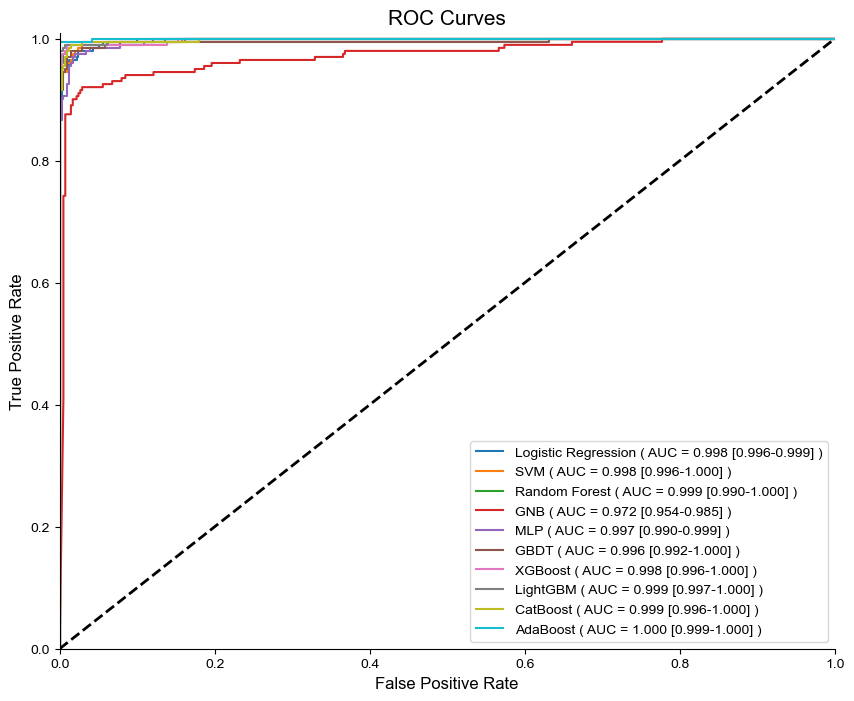

In [102]:
# 绘制ROC曲线

# 设置字体为Arial
plt.rcParams['font.family'] = 'Arial'

plt.figure(figsize=(10, 8))
for name, (fpr, tpr, auc) in roc_curves.items():
    lower_bound, upper_bound = conf_intervals[name]
    plt.plot(fpr, tpr, label=f'{name} ( AUC = {auc:.3f} [{lower_bound:.3f}-{upper_bound:.3f}] )')

plt.plot([0, 1], [0, 1], 'k--', lw=2)
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.01])
plt.xlabel('False Positive Rate', fontsize=12)
plt.ylabel('True Positive Rate', fontsize=12)
plt.title('ROC Curves', fontsize=15)
plt.legend(loc='lower right')

# 移除右边和上边边界
plt.gca().spines['right'].set_visible(False)
plt.gca().spines['top'].set_visible(False)

plt.grid(False)

# 保存为矢量图
plt.savefig(result_path + '46rna10折ROC.svg', format='svg')  # 保存为SVG格式
# plt.savefig('ROC_Curves.pdf', format='pdf')  # 保存为PDF格式（取消注释以使用）

plt.show()

In [103]:
##测试集标注
y_test = test_df_filtered['group']
X_test = test_df_filtered[mydf['Analytes']].fillna(0)

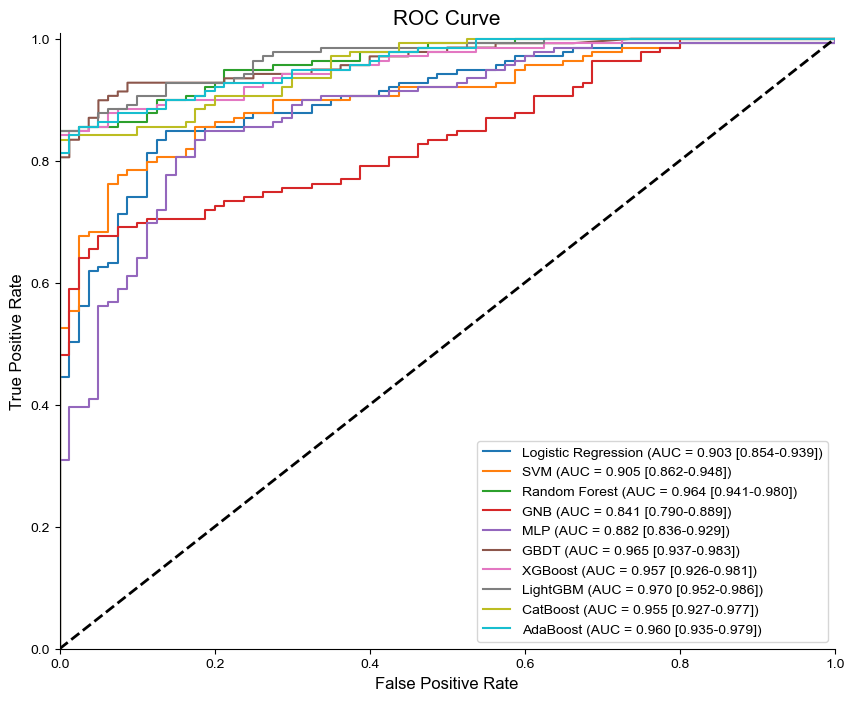

                 Model                  AUC             Accuracy  \
0  Logistic Regression  0.903 [0.854-0.939]  0.799 [0.717-0.849]   
1                  SVM  0.905 [0.862-0.948]  0.790 [0.667-0.785]   
2        Random Forest  0.964 [0.941-0.980]  0.886 [0.840-0.927]   
3                  GNB  0.841 [0.790-0.889]  0.763 [0.708-0.813]   
4                  MLP  0.882 [0.836-0.929]  0.763 [0.703-0.822]   
5                 GBDT  0.965 [0.937-0.983]  0.909 [0.849-0.941]   
6              XGBoost  0.957 [0.926-0.981]  0.872 [0.822-0.913]   
7             LightGBM  0.970 [0.952-0.986]  0.900 [0.854-0.950]   
8             CatBoost  0.955 [0.927-0.977]  0.886 [0.840-0.927]   
9             AdaBoost  0.960 [0.935-0.979]  0.895 [0.717-0.826]   

           Sensitivity          Specificity         Youden Index  \
0  0.748 [0.625-0.769]  0.887 [0.871-0.987]  0.636 [0.521-0.732]   
1  0.705 [0.514-0.667]  0.938 [0.938-1.000]  0.643 [0.486-0.654]   
2  0.820 [0.752-0.881]  1.000 [1.000-1.000]  0.

In [104]:
from sklearn.utils import resample
import numpy as np
import matplotlib.pyplot as plt
from sklearn.metrics import roc_auc_score, roc_curve, accuracy_score, recall_score, confusion_matrix, precision_score, f1_score, matthews_corrcoef
import pandas as pd

# 创建一个空的列表来存储每个模型的结果
results = []

plt.figure(figsize=(10, 8))  # 创建一个新的图形

# 外部验证测试
for name, model in best_models.items():
    # 计算模型的决策函数得分，如果没有 decision_function，则使用 predict_proba
    if hasattr(model, "decision_function"):
        y_score = model.decision_function(X_test)
    else:
        y_score = model.predict_proba(X_test)[:, 1]

    # 计算ROC曲线参数
    fpr, tpr, thresholds = roc_curve(y_test, y_score)
    auc = roc_auc_score(y_test, y_score)
    
    # 计算其他指标
    y_pred = model.predict(X_test)
    accuracy = accuracy_score(y_test, y_pred)
    sensitivity = recall_score(y_test, y_pred)
    tn, fp, fn, tp = confusion_matrix(y_test, y_pred).ravel()
    specificity = tn / (tn + fp)
    ppv = precision_score(y_test, y_pred)  # PPV
    npv = tn / (tn + fn)  # NPV
    f1 = f1_score(y_test, y_pred)  # F1 Score
    mcc = matthews_corrcoef(y_test, y_pred)  # MCC
    youden_index = sensitivity + specificity - 1
    
    # 使用自举法计算AUC和其他性能指标的95%置信区间
    n_bootstraps = 1000
    auc_scores, accuracy_scores, sensitivity_scores, specificity_scores = [], [], [], []
    ppv_scores, npv_scores, f1_scores, mcc_scores, youden_index_scores = [], [], [], [], []
    
    for _ in range(n_bootstraps):
        # 自举采样
        y_test_resampled, y_score_resampled = resample(y_test, y_score, random_state=np.random.randint(1, 100))
        auc_resampled = roc_auc_score(y_test_resampled, y_score_resampled)
        auc_scores.append(auc_resampled)

        # 根据新的y_test采样重新计算性能指标
        y_pred_resampled = np.where(y_score_resampled > 0.5, 1, 0)
        accuracy_scores.append(accuracy_score(y_test_resampled, y_pred_resampled))
        sensitivity_scores.append(recall_score(y_test_resampled, y_pred_resampled))
        tn_resampled, fp_resampled, fn_resampled, tp_resampled = confusion_matrix(y_test_resampled, y_pred_resampled).ravel()
        specificity_scores.append(tn_resampled / (tn_resampled + fp_resampled))
        ppv_scores.append(precision_score(y_test_resampled, y_pred_resampled))
        npv_scores.append(tn_resampled / (tn_resampled + fn_resampled))
        f1_scores.append(f1_score(y_test_resampled, y_pred_resampled))
        mcc_scores.append(matthews_corrcoef(y_test_resampled, y_pred_resampled))
        youden_index_scores.append(sensitivity_scores[-1] + specificity_scores[-1] - 1)
    
    # 计算各项指标的95%置信区间
    def compute_ci(scores):
        sorted_scores = np.array(scores)
        sorted_scores.sort()
        lower = sorted_scores[int(0.025 * len(sorted_scores))]
        upper = sorted_scores[int(0.975 * len(sorted_scores))]
        return lower, upper
    
    auc_ci = compute_ci(auc_scores)
    accuracy_ci = compute_ci(accuracy_scores)
    sensitivity_ci = compute_ci(sensitivity_scores)
    specificity_ci = compute_ci(specificity_scores)
    ppv_ci = compute_ci(ppv_scores)
    npv_ci = compute_ci(npv_scores)
    f1_ci = compute_ci(f1_scores)
    mcc_ci = compute_ci(mcc_scores)
    youden_index_ci = compute_ci(youden_index_scores)
    
    # 绘制ROC曲线
    plt.plot(fpr, tpr, label=f'{name} (AUC = {auc:.3f} [{auc_ci[0]:.3f}-{auc_ci[1]:.3f}])')

    # 存储每个模型的结果，包括置信区间
    results.append({
        'Model': name,
        'AUC': f'{auc:.3f} [{auc_ci[0]:.3f}-{auc_ci[1]:.3f}]',
        'Accuracy': f'{accuracy:.3f} [{accuracy_ci[0]:.3f}-{accuracy_ci[1]:.3f}]',
        'Sensitivity': f'{sensitivity:.3f} [{sensitivity_ci[0]:.3f}-{sensitivity_ci[1]:.3f}]',
        'Specificity': f'{specificity:.3f} [{specificity_ci[0]:.3f}-{specificity_ci[1]:.3f}]',
        'Youden Index': f'{youden_index:.3f} [{youden_index_ci[0]:.3f}-{youden_index_ci[1]:.3f}]',
        'PPV': f'{ppv:.3f} [{ppv_ci[0]:.3f}-{ppv_ci[1]:.3f}]',
        'NPV': f'{npv:.3f} [{npv_ci[0]:.3f}-{npv_ci[1]:.3f}]',
        'F1 Score': f'{f1:.3f} [{f1_ci[0]:.3f}-{f1_ci[1]:.3f}]',
        'MCC': f'{mcc:.3f} [{mcc_ci[0]:.3f}-{mcc_ci[1]:.3f}]'
    })

# 绘制随机猜测线
plt.plot([0, 1], [0, 1], 'k--', lw=2)
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.01])

# 添加标签和图例
plt.xlabel('False Positive Rate', fontsize=12)
plt.ylabel('True Positive Rate', fontsize=12)
plt.title('ROC Curve', fontsize=15)
plt.legend(loc="lower right")

# 移除右边和上边边界
plt.gca().spines['right'].set_visible(False)
plt.gca().spines['top'].set_visible(False)

# 保存ROC曲线为矢量图
plt.savefig(result_path + '46rna外部测试ROC.svg', format='svg')

# 显示绘图
plt.show()

# 将结果转换为DataFrame并显示
results_df = pd.DataFrame(results)
print(results_df)

# 将结果数据框保存为CSV文件
results_df.to_csv(result_path + '46rna_results.csv', index=False)


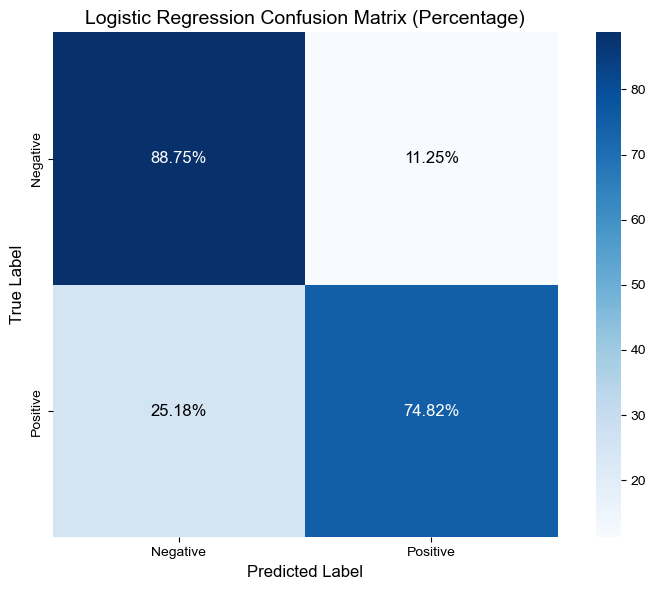

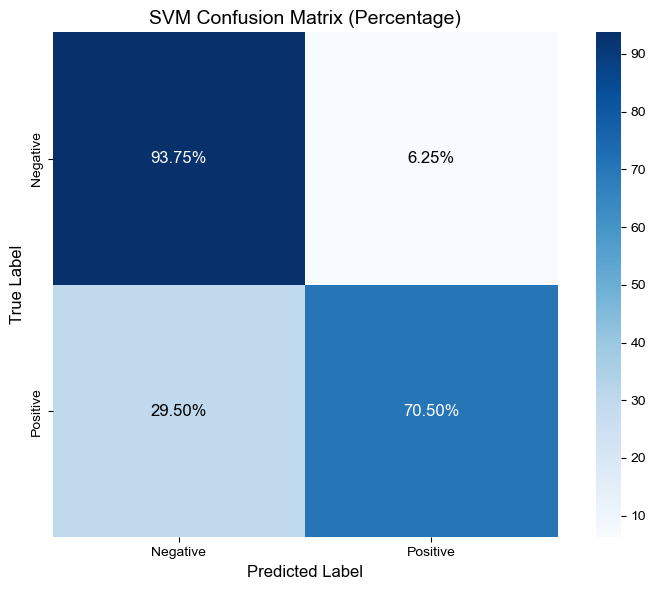

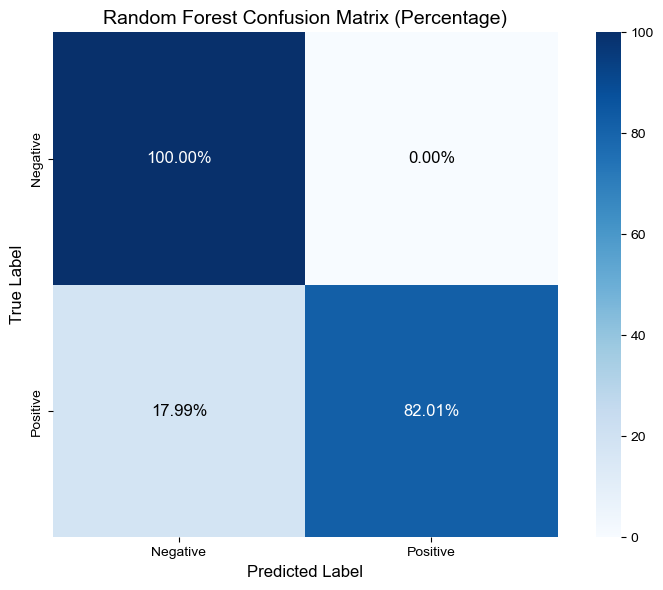

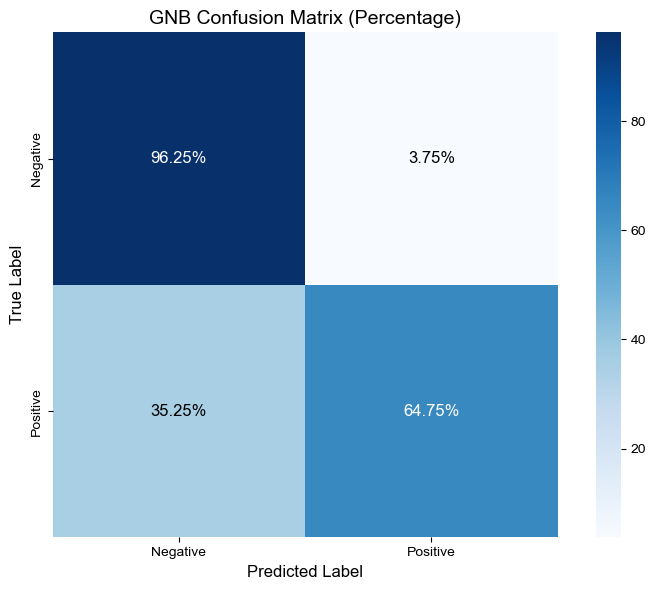

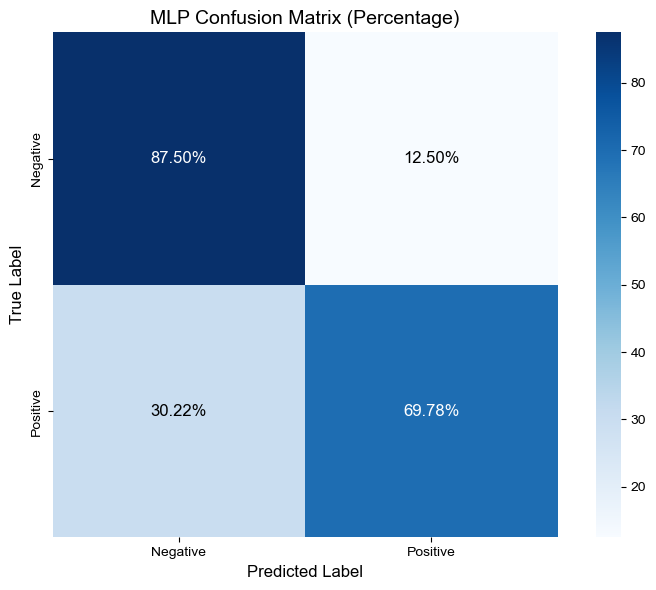

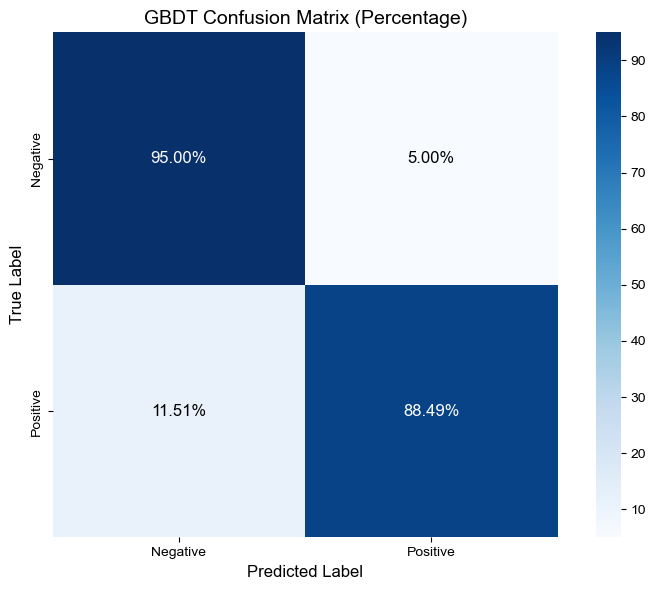

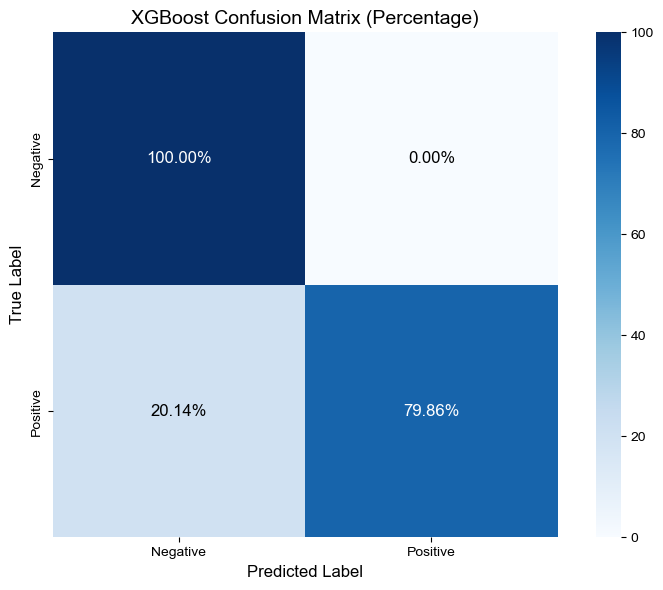

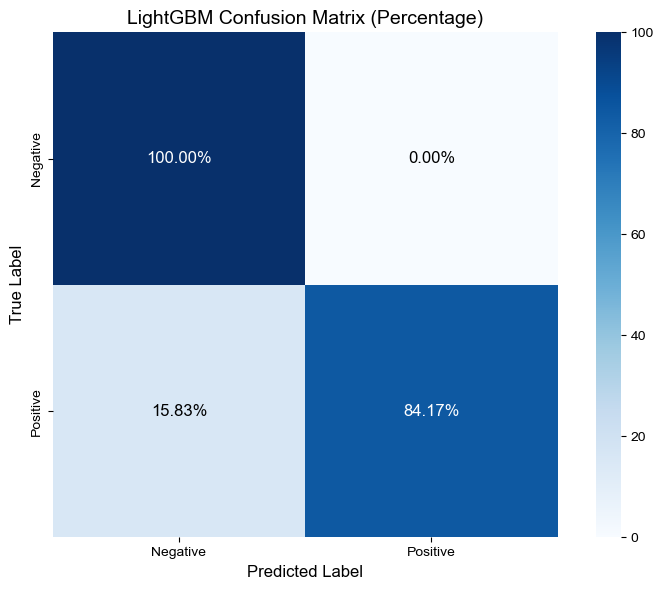

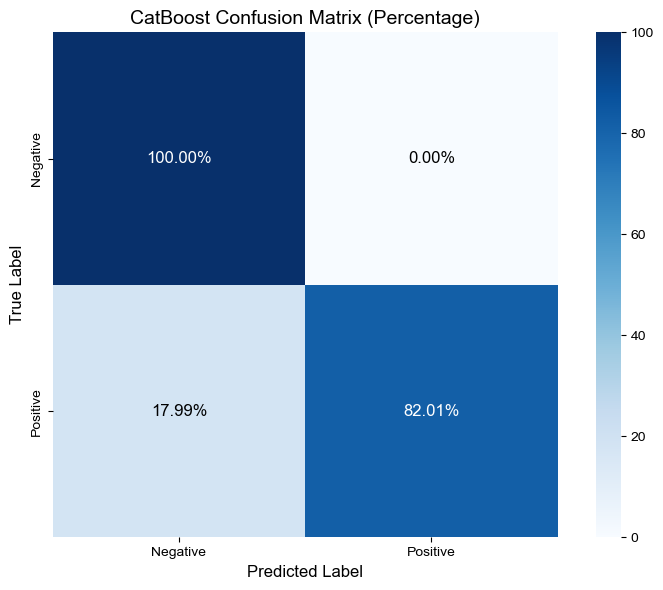

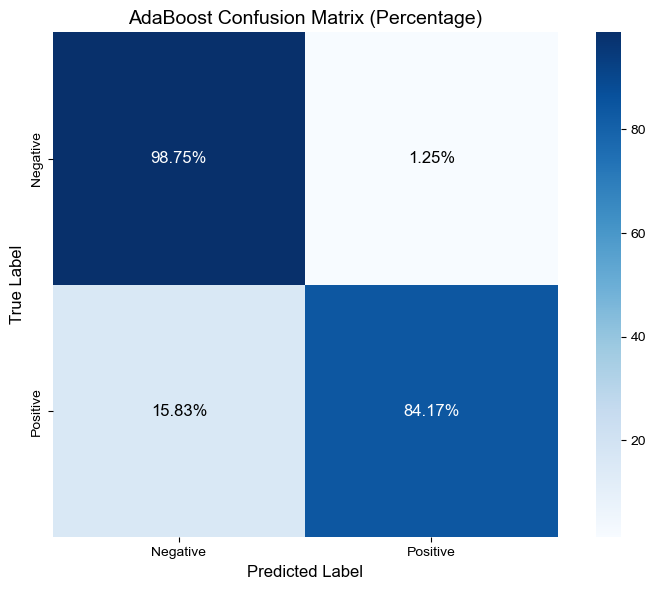

In [105]:
import seaborn as sns
from sklearn.metrics import confusion_matrix
import matplotlib.pyplot as plt
import numpy as np

# 遍历每个模型，绘制混淆矩阵
for name, model in best_models.items():
    # 使用最佳模型进行预测
    y_test_pred = model.predict(X_test)
    
    # 计算混淆矩阵
    cm = confusion_matrix(y_test, y_test_pred)
    
    # 将混淆矩阵数值转换为百分比
    cm_percentage = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis] * 100
    
    # 创建一个图形
    plt.figure(figsize=(8, 6))
    
    # 使用Seaborn的heatmap绘制混淆矩阵，数值用百分数表示
    sns.heatmap(cm_percentage, annot=False, fmt=".2f", cmap='Blues', cbar=True, square=True,
                xticklabels=['Negative', 'Positive'], 
                yticklabels=['Negative', 'Positive'])
    
    # 添加数字到热图上，使用反色
    for i in range(cm_percentage.shape[0]):
        for j in range(cm_percentage.shape[1]):
            # 根据百分比值设置文本颜色
            color = 'black' if cm_percentage[i, j] < 50 else 'white'
            plt.text(j + 0.5, i + 0.5, f"{cm_percentage[i, j]:.2f}%", 
                     ha='center', va='center', color=color, fontsize=12)
    
    # 添加标题和标签
    plt.title(f'{name} Confusion Matrix (Percentage)', fontsize=14)
    plt.xlabel('Predicted Label', fontsize=12)
    plt.ylabel('True Label', fontsize=12)
    
    # 显示混淆矩阵
    plt.tight_layout()
    
    # 保存为文件
    plt.savefig(f'{result_path}{name}_confusion_matrix.svg', format='svg')
    
    # 显示图像
    plt.show()



In [106]:
import joblib

# 保存每个最佳模型
for name, model in best_models.items():
    joblib.dump(model, f'{result_path}/model/{name}_model.pkl')
    print(f"{name} model saved successfully.")

Logistic Regression model saved successfully.
SVM model saved successfully.
Random Forest model saved successfully.
GNB model saved successfully.
MLP model saved successfully.
GBDT model saved successfully.
XGBoost model saved successfully.
LightGBM model saved successfully.
CatBoost model saved successfully.
AdaBoost model saved successfully.
